 <font size="6">Генерация и отбор признаков</font>


# Проблемы при работе с реальными данными

В реальных задачах вы столкнетесь с широким спектром трудностей, и одним из первых этапов будет подготовка данных. Уже на этом этапе есть ряд возможных проблем, например:

- **Нехватка данных** — у вас может быть мало данных. Более того, понять, какой объем данных необходим, — тоже отдельная задача. Другая вариация похожей проблемы — это большой объем данных, но без разметки.

- **Некачественная разметка** —  даже в широко известных MNIST, CIFAR-10 и ImageNet есть [ошибки в разметке 🎮[demo]](https://labelerrors.com/). В вашем датасете они тоже будут. Важно понимать, что разметка может не являться бесспорным эталоном.

- **Шум в данных** — полезно подумать о потенциальной зашумленности данных. Например, когда люди заполняют таблицы, они могут допускать ошибки. Хорошо понимать, какого рода ошибки могут содержаться в ваших данных.

- **Несбалансированность датасета** — какие-то классы могут быть плохо представлены (**минорные классы**). Например, если в вашем датасете будет всего 10 фотографий одного класса и 10 000 другого, то модели будет очень заманчиво вообще не пытаться определять минорный класс (всего 0.1% ошибок).

- **Ковариантный сдвиг** — явление, когда признаки тренировочной и тестовой выборок **распределены по-разному**. Из-за этого мы можем получать плохие предсказания на тестовой выборке, когда модель просто не знает, что признаки могут находиться в другом распределении ([подробнее 🥨 [colab]](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Classic_ML/covariate_shift.ipynb))

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/covariate_shift.png" width="600"></center>

*Практический совет: для быстрого обнаружения ковариантного сдвига можно **обучить модель**, которая будет предсказывать, относится ли объект к **train** или **test** выборке. Если модель легко делит данные по такому принципу, то имеет смысл визуализировать значения признаков, по которым она это делает.*

- **Малое число источников данных** — проблема, родственная предыдущей. В вашем датасете могут быть данные только от одного прибора или одной модели прибора. Могут быть данные, снятые только одним специалистом, или в одной больнице, или только у взрослых. Это также может влиять на способность вашего алгоритма обобщать полученное решение и требует пристального внимания.

- **Грязные данные** — в данных могут быть полные/неполные дубликаты, пропуски, ошибки форматов, перемешанные столбцы и многое другое. Такие проблемы могут быть как естественной характеристикой (нет данных о каких-то объектах, отсюда пропуски), так и ошибкой при агрегации данных из разных источников. Важно подумать о проверках и тестах, чтобы быть уверенным в качестве.

Все это приводит к целому спектру сложностей, из которых самой типичной будет переобучение модели — какую бы простую модель вы не взяли, она все равно будет выучивать искажения вашего датасета.

## Дисбаланс классов

Прежде всего надо убедиться, что датасет сбалансирован:

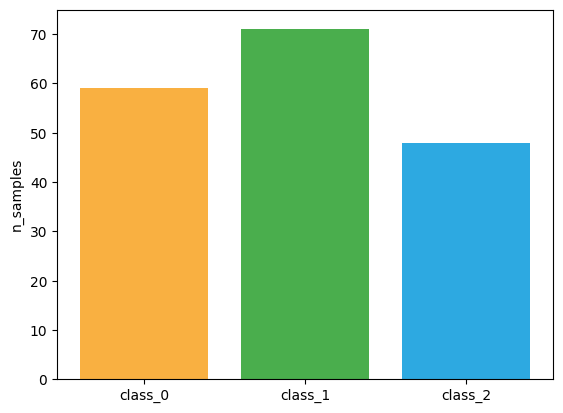

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine


def show_class_balance(y, classes):
    _, counts = torch.unique(torch.tensor(y), return_counts=True)
    plt.bar(classes, counts, color=["#F9B041", "#4AAE4D", "#2DA9E1"])
    plt.ylabel("n_samples")
    plt.ylim([0, 75])
    plt.show()


wine = load_wine()
classes = wine.target_names

show_class_balance(wine.target, classes)

Разница в 10–20% будет незначительна, поэтому для наглядности мы искусственно создадим дисбаланс в датасете при помощи метода `make_imbalance` [🛠️[doc]](https://imbalanced-learn.org/stable/references/generated/imblearn.datasets.make_imbalance.html) из библиотеки [imbalanced-learn 🛠️[doc]](https://imbalanced-learn.org/stable/).

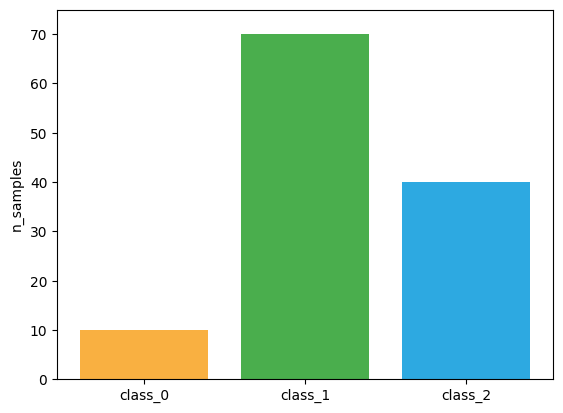

In [2]:
from imblearn.datasets import make_imbalance


x, y = make_imbalance(
    wine.data, wine.target, sampling_strategy={0: 10, 1: 70, 2: 40}, random_state=42
)
show_class_balance(y, classes)

### Изменение баланса класса семплированием

Если в данных нехватка именно конкретного класса, то можно бороться с этим при помощи разных способов семплирования.

Важно понимать, что в большинстве случаев данные, полученные таким способом, должны использоваться в качестве **обучающего набора**, но ни в коем случае не для **валидации** или **теста**.

#### Дублирование примеров меньшего класса (oversampling)

Мы можем увеличить число объектов меньшего класса за счет дублирования.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/oversampling_scheme.png" width="600"></center>

<center><em>Дублирование примеров меньшего класса</em></center>



Такой oversampling может быть выполнен с помощью класса `RandomOverSampler` [🛠️[doc]](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) из [imbalanced-learn🛠️[doc]](https://imbalanced-learn.org/stable/), как показано ниже:

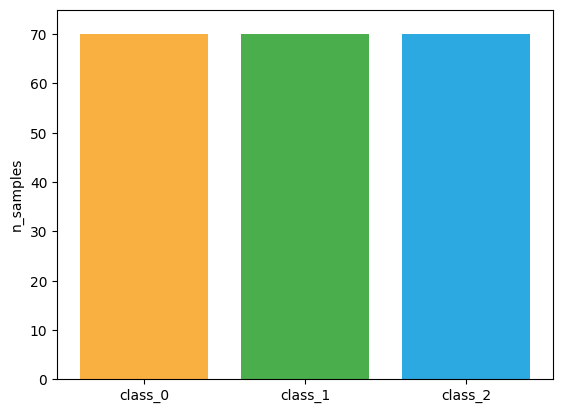

In [3]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(x, y)

show_class_balance(y_ros, classes)

#### Уменьшение числа примеров большего класса (undersampling)

Аналогично, можно взять для обучения не всех представителей большего класса.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/undersampling_scheme.png" width="600"></center>

<center><em>Удаление примеров преобладающего класса</em></center>

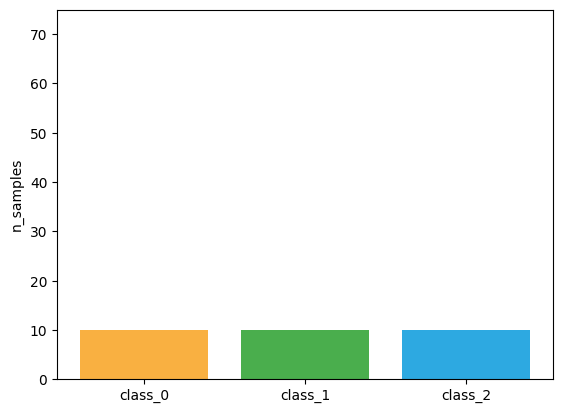

In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(x, y)

show_class_balance(y_res, classes)

Минус подхода: мы можем выбросить важные объекты большего класса, существенно улучшающие качество генерализации, и из-за этого качество модели существенно ухудшится.

Выбрасывать объекты большего класса  можно разными способами. Например, кластеризовать объекты большего класса и брать по заданному количеству объектов из каждого кластера.

#### Ансамбли + undersampling

Можно использовать ансамбли вместе с undersampling. В этом случае мы можем, к примеру, делать семплирование только большего класса, а объекты минорного класса оставлять как есть.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/ensembles_and_undersampling.png" width="700px"></center>

Или просто семплировать объекты и того, и другого класса в равном количестве.

### Генерация синтетических данных





**Synthetic Minority Over-sampling Technique (SMOTE)** позволяет генерировать синтетические данные за счет реальных объектов из минорного класса.

Алгоритм работает следующим образом:

1. Для случайной точки из минорного класса выбираем $k$ ближайших соседей из того же класса.
2. Для первого соседа проводим отрезок, соединяющий его и выбранную точку. На этом отрезке случайно выбираем точку.
3. Эта точка — новый **синтетический** объект минорного класса.
4. Повторяем процедуру для оставшихся соседей.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/generate_synthetic_data.png" width="700"></center>

Число соседей, как и число раз, которое мы запускаем описанную выше процедуру, можно регулировать.

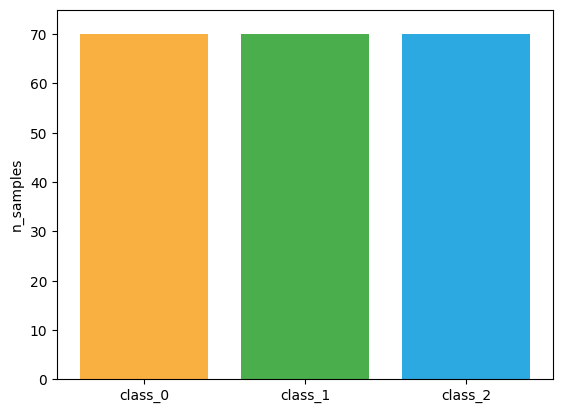

In [5]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x, y)

show_class_balance(y_smote, classes)

Количество объектов каждого класса, которое должно получиться после генерации, можно задать явно:

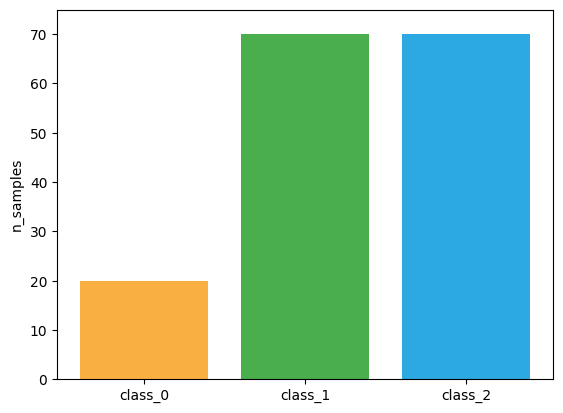

In [6]:
over = SMOTE(sampling_strategy={0: 20, 1: 70, 2: 70})
x_smote, y_smote = over.fit_resample(x, y)

show_class_balance(y_smote, classes)

[[blog] ✏️ SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) — подробнее про использование пакета.

## Обнаружение аномалий

В случае сильно несбалансированных наборов данных стоит задуматься, могут ли такие примеры рассматриваться как аномалия (выброс) или нет. Если такое событие и впрямь может считаться аномальным, мы можем использовать такие модели, как One-Class SVM, или методы кластеризации.

Эти методы требуют изменения взгляда на задачу: мы будем рассматривать аномалии как отдельный класс выбросов. Это может помочь нам найти новые способы разделения и классификации.

Пусть мы хотим отличать фрукты по каким-то признакам, скажем, по форме и цвету, и мы имеем выборку, где много яблок и груш. Задача обнаружения аномалий возникает, если мы предполагаем, что среди яблок и груш может вдруг возникнуть клубника, и нам нужно не отнести ее к одному из известных классов, а выделить в отдельный, отличающийся класс.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/anomaly_fruits.png" width="800"></img></center>

Проблемой при работе с аномалиями является то, что аномальных значений может быть очень мало или вообще не быть. В таком случае алгоритм учит паттерны нормального поведения и реагирует на отличия от паттернов.

Разберем примеры обнаружения аномалий с помощью трех алгоритмов из библиотеки Scikit-Learn (там можно найти еще много различных алгоритмов).

Создадим датасет из двух кластеров и случайных значений.

In [7]:
import numpy as np

rng = np.random.RandomState(42)

# Train
x = 0.3 * rng.randn(100, 2)  # 100 2D points
x_train = np.r_[x + 2, x - 2]  # split into two clusters

# Test norlmal
x = 0.3 * rng.randn(20, 2)  # 20 2D points
x_test_normal = np.r_[x + 2, x - 2]  # split into two clusters

# Test outliers
x_test_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

Напишем функцию визуализации, которая будет изображать созданный датасет на рисунке слева, а результат поиска аномалий — на рисунке справа.

In [8]:
def plot_outliers(x_train, x_test_normal, x_test_outliers, model=None):
    fig, (plt_data, plt_model) = plt.subplots(1, 2, figsize=(12, 6))

    plt_data.set_title("Created Dataset (real labels)")
    plot_train = plt_data.scatter(
        x_train[:, 0], x_train[:, 1], c="white", s=40, edgecolor="k"
    )
    plot_test_normal = plt_data.scatter(
        x_test_normal[:, 0], x_test_normal[:, 1], c="green", s=40, edgecolor="k"
    )
    plot_test_outliers = plt_data.scatter(
        x_test_outliers[:, 0], x_test_outliers[:, 1], c="red", s=40, edgecolor="k"
    )

    plt_data.set_xlim((-5, 5))
    plt_data.set_ylim((-5, 5))

    plt_data.legend(
        [plot_train, plot_test_normal, plot_test_outliers],
        ["train", "test normal", "test outliers"],
        loc="lower right",
    )

    if model:
        plt_model.set_title("Model Results")
        # Plot decision function
        xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt_model.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

        # Plot prediction
        full_data = np.concatenate((x_train, x_test_normal, x_test_outliers), axis=0)
        predicted = model.predict(full_data)

        anom_index = np.where(predicted == -1)
        anom_values = full_data[anom_index]

        plot_all_data = plt_model.scatter(
            full_data[:, 0], full_data[:, 1], c="white", s=40, edgecolor="k"
        )

        plot_anom_data = plt_model.scatter(
            anom_values[:, 0], anom_values[:, 1], c="red", s=40, marker="x"
        )
        plt_model.legend(
            [plot_all_data, plot_anom_data],
            ["normal", "outliers"],
            loc="lower right",
        )
    plt.show()

Посмотрим, как работает на этих данных алгоритм [One-Class SVM 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html).

One-Class SVM (One-Class Support Vector Machine) работает следующим образом: алгоритм обучается на нормальных данных и создает в многомерном пространстве гиперплоскость, которая максимально отделяет большинство данных от начала координат. После обучения новые наблюдения, которые оказываются далеко от этой гиперплоскости (внутри или снаружи), рассматриваются как аномалии.

Подробнее об алгоритме:

[[article] 🎓 Support Vector Method for Novelty Detection](https://proceedings.neurips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf)



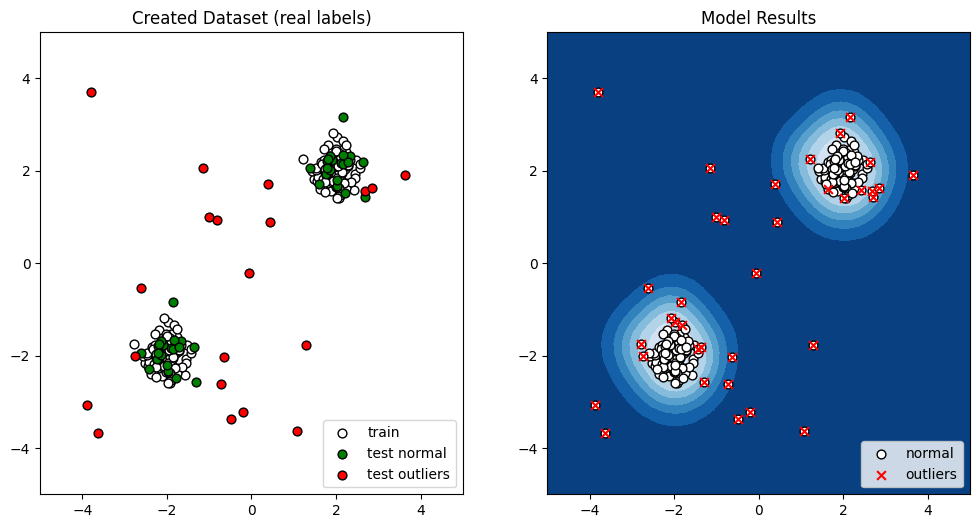

In [9]:
from sklearn.svm import OneClassSVM

gamma = 2.0  # kernel coefficient
contamination = 0.05  # threshold

model = OneClassSVM(gamma=gamma, kernel="rbf", nu=contamination)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

Посмотрим, как на этих же данных работает алгоритм [Isolation Forest 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Isolation Forest состоит из деревьев, которые «изолируют» (пытаются отделить от остальной выборки) наблюдения, случайным образом выбирая признак и случайное значение порога для этого признака (между максимальным и минимальным значениями признака). Если построить по такому принципу множество деревьев, то значения, которые чаще других отделяются раньше, будут аномалиями.

На практике часто используют более продвинутую версию [Extended Isolation Forest
🐾[git]](https://github.com/sahandha/eif).


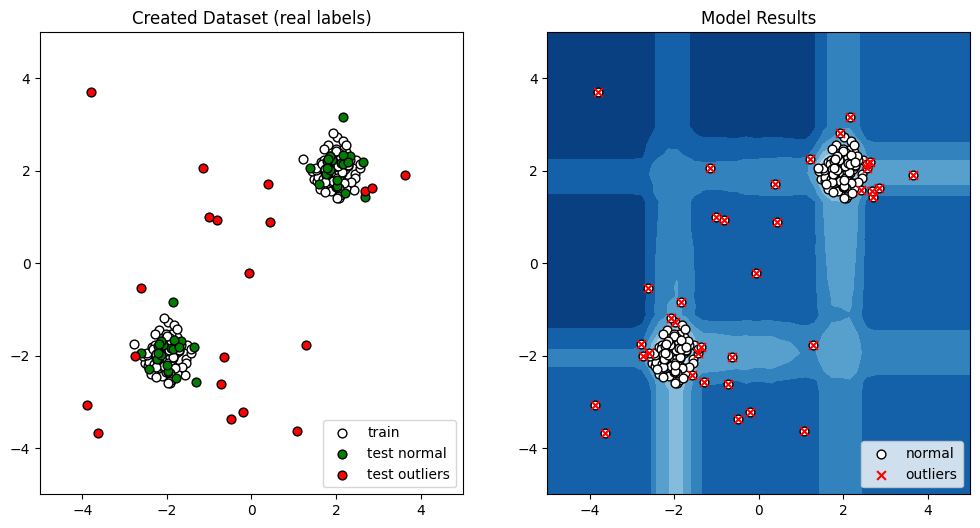

In [10]:
from sklearn.ensemble import IsolationForest

n_estimators = 200
contamination = 0.05  # threshold

model = IsolationForest(
    n_estimators=n_estimators, contamination=contamination, random_state=rng
)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

Последним алгоритмом, на который мы посмотрим, будет [Local Outlier Factor 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

В нем используется метод k-NN. Расстояние до ближайших соседей используется для оценки расположения точек. Если соседи далеко, то точка с большой вероятностью является аномалией.

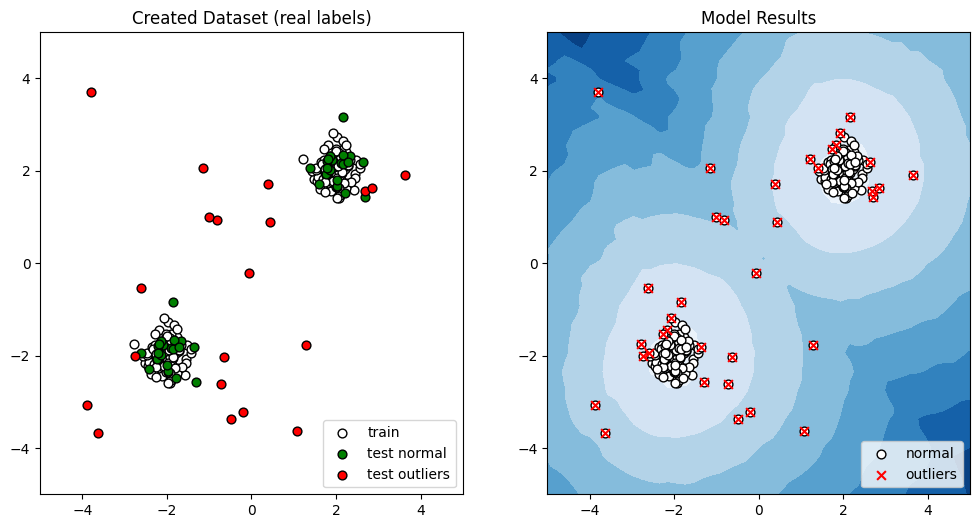

In [11]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = 10
contamination = 0.05  # threshold

model = LocalOutlierFactor(
    n_neighbors=n_neighbors, novelty=True, contamination=contamination
)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

### Оценка качества в задаче обнаружения аномалий

Отдельное время стоит посвятить подбору порога для алгоритма.

Порог является граничным значением, выше которого данные считаются аномальными. Выбор порога — это компромиссное решение: слишком низкий порог может привести к ложным срабатываниям, тогда как слишком высокий порог может пропустить аномалии. Поэтому выбор порога напрямую связан с задачей и требованиям к детекции.

Построим матрицы ошибок (confusion matrix) для разных порогов:


In [12]:
full_data = np.concatenate((x_train, x_test_normal, x_test_outliers), axis=0)
predicted = model.predict(full_data)

# Change threshold to 0.005
model_2 = LocalOutlierFactor(n_neighbors=10, novelty=True, contamination=0.005)
model_2.fit(x_train)
predicted_2 = model_2.predict(full_data)

y_true = np.ones(full_data.shape[0])  # create true labels
y_true[-x_test_outliers.shape[0] :] = -1  # last 20 is anomaly

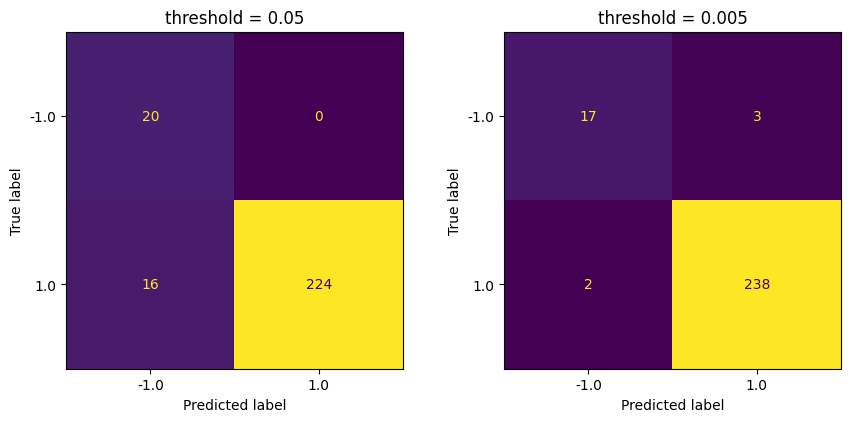

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ConfusionMatrixDisplay.from_predictions(y_true, predicted, ax=ax1, colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_true, predicted_2, ax=ax2, colorbar=False)
ax1.set_title("threshold = 0.05")
ax2.set_title("threshold = 0.005")
plt.subplots_adjust(wspace=0.3)
plt.show()

Еще одна идея улучшения качества детекции аномалий — это агрегация результатов разных алгоритмов, т. е. создание ансамбля.

# Кодирование признаков




**Кодирование признаков** &mdash; процесс описания данных в численном представлении.







Изначально объекты в нашем датасете могут быть представлены в виде описаний, которые не являются численными или требуют некоторой предобработки. Например:

*   тексты
*   формулы химических веществ
*   строки со значениями и единицами измерений (сантиметры, метры и т.д.) и др.

Большая часть моделей не способна работать с такими представлениями в сыром виде и просто не запустится или будет выдавать неадекватные результаты.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/process_of_generation_features.png" width="700"></center>

**Пример на датасете Titanic**

Для иллюстрации будут использованы примеры из книги "[Real-World Machine Learning" 📚[book]](https://www.manning.com/books/real-world-machine-learning) из открытого [репозитория 🐾[git]](https://github.com/brinkar/real-world-machine-learning) и датасет [Titanic 🛠️[doc]](https://www.kaggle.com/datasets/brendan45774/test-file).

Данный датасет представляет собой список пассажиров судна.
В отличие от датасетов, с которыми мы работали раньше, данные в нем не предобработаны и в сыром виде не могут быть использованы для обучения модели.

In [114]:
import pandas as pd

# Download the data and save it in a variable called data
dataset = pd.read_csv(
    "https://ml.gan4x4.ru/msu//datasets/titanic.csv"
)  # Load the data using pandas
dataset[:5]  # Show the first 5 lines

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


*  SibSp — количество братьев/сестер/супругов на борту Титаника.
*  Parch — количество родителей/детей на борту.
*  Embarked — порт посадки (C = Cherbourg; Q = Queenstown; S = Southampton).

Если мы попытаемся обучить модель на таких данных, то у нас ничего не выйдет.

In [15]:
from sklearn.ensemble import RandomForestClassifier

x = dataset.drop("Survived", axis=1)  # drop target
y = dataset["Survived"]  # target

rf = RandomForestClassifier(random_state=42)

try:
    rf.fit(x, y)
except ValueError as e:
    print(e)

could not convert string to float: 'Braund, Mr. Owen Harris'


## Типы признаков

Традиционно признаки делятся на вещественные и категориальные.

### Вещественные

Вещественные признаки бывают:

 * **Дискретные**. Например, число лайков от пользователей.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/discrete_features_social_media_likes.jpg" width="1000"></center>

В датасете Титаник таким параметром будет SibSp — количество братьев/сестер/супругов на борту.

In [16]:
print(dataset["SibSp"].unique())

[1 0 3 4 2 5 8]


Или Parch — количество родителей/детей на борту.

In [17]:
print(dataset["Parch"].unique())

[0 1 2 5 3 4 6]


 * **Непрерывные**. Например, температура.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/continuous_features_thermometer.png" width="600"></center>

Разделение условное. Тот же возраст можно посчитать и дискретной переменной (пользователь всегда нам сообщает свои полные года), и непрерывной (возраст можно считать с любой точностью)


In [18]:
dataset[["Age", "Fare"]].head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


Попробуем обучить модель на вещественных признаках. PassengerId удалим, т.к. этот признак может приводить к утечке в данных.

In [19]:
from sklearn.model_selection import train_test_split


x = dataset.drop(columns=["Survived", "PassengerId"])  # drop target and id
y = dataset["Survived"]  # target

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
# drop categorical
x_train_working = x_train.drop(
    columns=["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
)
x_test_working = x_test.drop(
    columns=["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
)

rf = RandomForestClassifier(random_state=42)

try:
    rf.fit(x_train_working, y_train)
except ValueError as e:
    print(e)

x_train_working.head()

,Age,SibSp,Parch,Fare
331,45.5,0,0,28.5000
733,23.0,0,0,13.0000
382,32.0,0,0,7.9250
704,26.0,1,0,7.8542
813,6.0,4,2,31.2750


Проблема в том, что Age указан только для 714 пассажиров из 891. Его мы пока тоже удалим.

In [20]:
from sklearn.metrics import accuracy_score


x_train_working = x_train_working.drop(columns=["Age"])
x_test_working = x_test_working.drop(columns=["Age"])

rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

print(accuracy_score(y_test, y_pred))

0.6759776536312849


Точность предсказания 67.6%. Для улучшения качества попробуем добавить другие признаки.

### Категориальные

Значение —  принадлежность к какой-то из категорий. Делятся на:
 * **Упорядоченные** (ординальные) — имееют порядок (иерархию), для каждой пары категорий можем сказать, какая больше, а какая меньше. Например, класс места или размер одежды.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/categorical_ordered_features.png" width="600"></center>

В датасете Титаник таким признаком будет класс пассажира. Мы можем сказать, что первый класс лучше третьего или второго.

In [21]:
print(dataset["Pclass"].unique())

[3 1 2]


* **Неупорядоченные** (номинальные) — категории между собой несравнимы. Обычно нельзя сказать, что желтая футболка больше синей или зеленая лучше, чем фиолетовая.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/categorical_unordered_features.png" width="600"></center>

Важно понимать, что могут быть ситуации, когда один и тот же признак может быть упорядоченным или неупорядоченным, в зависимости от задачи и наших знаний о ней. Например, цвет в спектре определяется длиной волны, и в физической задаче цвета можно упорядочить.

В датасете Титаник таким признаком является Embarked (порт посадки).

In [22]:
print(dataset["Embarked"].unique())
# C = Cherbourg; Q = Queenstown; S = Southampton

['S' 'C' 'Q' nan]


Часто мы сталкиваемся с бинарными категориальными признаками, для которых известны только две возможные категории (например, биологический пол человека).

In [23]:
print(dataset["Sex"].unique())

['male' 'female']


## Преобразования признаков



Существует много подходов к кодированию признакового пространства. Каждый подход имеет свои особенности. Способ кодирования зависит от используемой модели.

### Категориальные признаки

#### Label encoding

В Label encoding каждая уникальная категория в столбце заменяется уникальным целым числом. Данный подход хорошо работает для упорядоченных признаков.

Например, есть признак с порядковыми значениями `["low", "medium", "high"]`. После кодирования получим `[0, 1, 2]`.


У нас есть упорядоченный категориальный признак — класс, которым ехал пассажир. Добавим его к данным.

In [24]:
x_train_working["Pclass"] = x_train["Pclass"]
x_test_working["Pclass"] = x_test["Pclass"]

x_train_working[:5]

,SibSp,Parch,Fare,Pclass
331,0,0,28.5000,1
733,0,0,13.0000,2
382,0,0,7.9250,3
704,1,0,7.8542,3
813,4,2,31.2750,3


Если признак неупорядоченный, то могут возникнуть проблемы.
Например, если мы обозначим `["Красный", "Желтый", "Зеленый"]` как `[1, 2, 3]`, то для нашей модели могут возникнуть ложные зависимости, которые не являются свойством данных.

Например, для линейных моделей: `Красный + Желтый = Зеленый`.

Кроме того, мы не можем сказать, что `"Желтый"` больше чем `"Красный"`, и сравнить его с `"Зеленым"`, но обучаемая модель про это не знает и будет пытаться их сравнить. Это может привести к низкому качеству модели и выучиванию ложных закономерностей.

#### One-hot encoding

Для неупорядочных категориальных признаков часто используется one-hot encoding.

Каждая уникальная категория в столбце преобразуется в новую бинарную колонку. В каждой из этих колонок значение будет равно 1, если наблюдение принадлежит данной категории, и 0 в противном случае.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/one_hot_encoding.png" width="450"></center>

У такой схемы есть ряд недостатков:
* Увеличение размерности признакового пространства. Если у нас большое количество категорий, то мы получим большое количество новых бинарных признаков, которые к тому же будут разрежены.

* При использовании случайного леса выбирается случайное подмножество признаков. Преобразованные во множество бинарных, категориальные признаки будут встречаться чаще, чем вещественные, что может привести к тому, что значимость категориальных признаков будет завышена.




У нас есть два признака с ограниченным количеством значений: Sex и Embarked.

Пол закодируем `male = 1`, `female = 0`.

In [25]:
x_train_working["Sex"] = x_train["Sex"].map({"male": 1, "female": 0})
x_test_working["Sex"] = x_test["Sex"].map({"male": 1, "female": 0})

x_train_working[:5]

,SibSp,Parch,Fare,Pclass,Sex
331,0,0,28.5000,1,1
733,0,0,13.0000,2,1
382,0,0,7.9250,3,1
704,1,0,7.8542,3,1
813,4,2,31.2750,3,0


#### Count encoding

Еще один способ, который показал свою эффективность, — это кодирование категориальной переменной по количеству встречаемости в данных.

|  category | new_feature |
|:---------:|:-----------:|
|    food   |      3      |
| equipment |      2      |
|    food   |      3      |
|  food     |      3      |
| equipment |      2      |
|  clothes  |      1      |

Его просто и быстро реализовать. Здесь также присутствует логика порядка, который возникает естественным образом. Чем больше число, тем чаще встречается категория. Также здесь отсутствует ложная линейная зависимость: в нашем случае `equipment + clothes = food`, и для нас это действительно так, потому что наше кодирование отражает связь между категориями через их частоту.

Дополнительно стоит добавить шум к данным, чтобы избежать ситуации, когда разные категории кодируются одинаковым числом.

|  category | new_feature |
|:---------:|:-----------:|
|    food   |      2.3    |
| equipment |      2.04   |
|    food   |      2.3    |
|  clothes  |      2.6    |
| equipment |      2.04   |
|  clothes  |      2.6    |

#### Кодирование по вещественному признаку

Можем кодировать категориальный признак по какой-то статистике вещественного.
Например, при прогнозировании покупок в интернет магазине может оказаться разумным кодировать категории товаров их средней ценой.

|  category |  product | price | new_feature |
|:---------:|:--------:|:-----:|:-----------:|
|    food   |   pizza  |   30  |      17     |
| equipment |  hammer  |  140  |     170     |
|    food   | cucumber |   4   |      17     |
|  clothes  |   boots  |  100  |      60     |
| equipment |  helmet  |  200  |     170     |
|  clothes  |  gloves  |   20  |      60     |

#### Target encoding

В Target encoding каждая категория кодируется численным параметром, характеризующим то, что мы предсказываем. Например, можно каждую категорию категориального признака заменять на среднее целевого значения (mean target).

При этом может возникнуть проблема переобучения: для редких классов модель может научиться копировать значение mean target категориального признака в ответ, игнорируя другие признаки.

Как с этим бороться:

[[git] 🐾 Курс "Прикладные задачи анализа данных", Генерация признаков](https://github.com/Dyakonov/PZAD/blob/master/2020/PZAD2020_042featureengineering_07.pdf)

Так как у нас в качестве модели используется случайный лес, для Embarked (порт посадки) будем использовать Label encoding. Используем Target, чтобы упорядочить метки. Посмотрим, какой процент выживших для каждого порта. Смотреть будем только на train выборке. Информация из test выборки не должна попасть в модель!

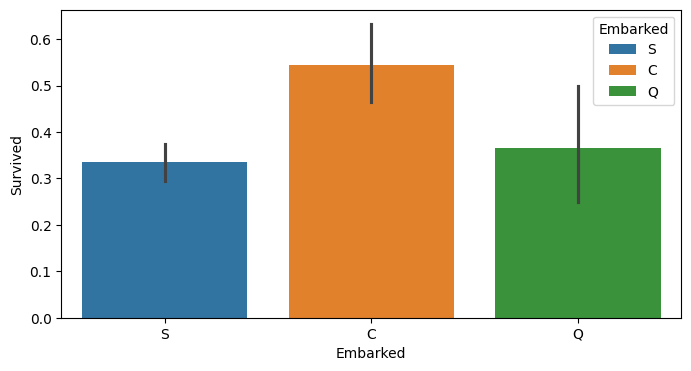

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 4))

train_df = x_train.copy()
train_df["Survived"] = y_train
sns.barplot(x="Embarked", y="Survived", data=train_df, hue="Embarked")
plt.show()

Получили количество выживших $S<Q<C$. Упорядочим метки соответственно.

In [27]:
import numpy as np

emb = {np.nan: 0, "S": 0, "Q": 1, "C": 2}

x_train_working["Embarked"] = x_train["Embarked"].map(emb)
x_test_working["Embarked"] = x_test["Embarked"].map(emb)

x_train_working[5:10]

,SibSp,Parch,Fare,Pclass,Sex,Embarked
118,0,1,247.5208,1,1,2
536,0,0,26.5500,1,1,0
361,1,0,27.7208,2,1,2
29,0,0,7.8958,3,1,0
55,0,0,35.5000,1,1,0


У нас осталось еще 4 признака, с которыми непонятно, что делать: Name, Ticket, Cabin, Age.

Рассмотрим поле Name. Это поле может включать информацию о поле, социальном статусе, происхождении, национальности, возрасте и т.д. Мы можем создать модели, которые будут оценивать и отображать эти характеристики. В следующих лекциях нашего курса мы будем работать с числовыми представлениями текста. Пока же мы можем проанализировать данные и формулировать гипотезы на основе уже имеющейся информации:

In [28]:
x_train.Name[:5]

,Name
331,"Partner, Mr. Austen"
733,"Berriman, Mr. William John"
382,"Tikkanen, Mr. Juho"
704,"Hansen, Mr. Henrik Juul"
813,"Andersson, Miss. Ebba Iris Alfrida"


В именах есть информация о социальном статусе:
- Miss — незамужняя женщина,
- Mrs — замужняя женщина,
- Master — несовершеннолетний мужчина,
- Mr — совершеннолетний мужчина,
- Dr — доктор,
- Rev — преподобный,
- Capt — капитан,

и т.д.

Первые 4 встречаются чаще.

Извлечем все возможные титулы. Они начинаются с пробела и заканчиваются точкой.

In [29]:
titles = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False).unique()
print(titles)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


Сгруппируем некоторые с похожими значениями. Редкие запишем в нулевой класс.

In [30]:
title_mapping = {"Mr": 4, "Miss": 3, "Mrs": 2, "Master": 1}

# Get title from name and encode by title_mapping, another titles fill zero
x_train_working["Title"] = (
    x_train.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    .map(title_mapping)
    .fillna(0)
)
x_test_working["Title"] = (
    x_test.Name.str.extract(" ([A-Za-z]+)\.", expand=False).map(title_mapping).fillna(0)
)

x_train_working[:5]

,SibSp,Parch,Fare,Pclass,Sex,Embarked,Title
331,0,0,28.5000,1,1,0,4.0
733,0,0,13.0000,2,1,0,4.0
382,0,0,7.9250,3,1,0,4.0
704,1,0,7.8542,3,1,0,4.0
813,4,2,31.2750,3,0,0,3.0


Некоторые модели (например, [CatBoost 🛠️[doc]](https://catboost.ai/en/docs/features/categorical-features)) могут автоматически подбирать кодировку для категориальных признаков, если предоставить им информацию о том, что признак категориальный, для других моделей это нужно делать вручную.


#### Кодирование циклических категориальных признаков

При работе с датой и временем мы можем представить дату и время в виде числа. Один из способов такого представления — [Unix Timestamp 🛠️[doc]](https://www.unixtimestamp.com/) (количество секунд, прошедших с 1 января 1970-го года).
Для ряда задач важна цикличность времени. Например, загруженность линии метро будет зависеть от времени дня (цикл 24 часа), дня недели (цикл 7 дней) и нерабочих праздничных дней (цикл год). Для прогнозирования количества электроэнергии, выработанной солнечной батареей, важно будет время дня (цикл 24 часа) и время года (цикл год).

В случае с такими признаками, как день недели или время суток, мы сталкиваемся с проблемой того, что нам нужно предложить кодирование, которое будет учитывать, что понедельник близок к воскресенью так же, как и ко вторнику, и т.д.


Давайте нанесем наши категории, например, дни недели, на окружность. Как это сделать?
Пусть понедельнику соответствует 1, а воскресенью — 7. Далее посчитаем два таких вспомогательных признака по следующим формулам

In [31]:
weekdays = np.arange(1, 8)  # create an array of weekdays
print(weekdays)
sina = np.sin(weekdays * np.pi * 2 / np.max(weekdays))  # feature 1
cosa = np.cos(weekdays * np.pi * 2 / np.max(weekdays))  # feature 2

[1 2 3 4 5 6 7]


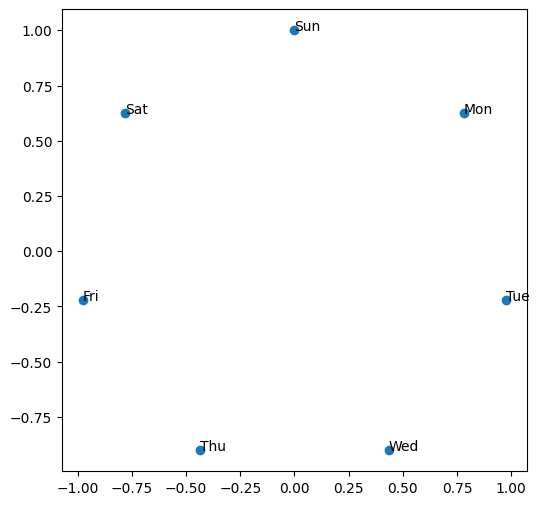

In [32]:
plt.figure(figsize=(6, 6))  # Decide figure size
plt.scatter(sina, cosa)  # Plot scatter of feature 1 vs feature 2
for i, z in enumerate(
    ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
):  # for each day in a week
    plt.text(sina[i], cosa[i], s=z)  # add text labels to plot

Теперь расстояния между понедельником и вторником и воскресеньем и понедельником одинаковые:

In [33]:
dist_mon_tue = (sina[1] - sina[0]) ** 2 + (
    cosa[1] - cosa[0]
) ** 2  # distance between Monday and Tuesday
dist_sun_mon = (sina[6] - sina[0]) ** 2 + (
    cosa[6] - cosa[0]
) ** 2  # distance between Sunday and Monday
print("Distance between Mon-Tue = %.2f" % dist_mon_tue)
print("Distance between Sun-Mon = %.2f" % dist_sun_mon)

Distance between Mon-Tue = 0.75
Distance between Sun-Mon = 0.75


То же самое верно и для любых отстоящих друг от друга на одинаковое число дней:

In [34]:
dist_mon_wed = (sina[2] - sina[0]) ** 2 + (
    cosa[2] - cosa[0]
) ** 2  # distance between Monday and Wednesday
dist_fri_sun = (sina[4] - sina[6]) ** 2 + (
    cosa[4] - cosa[6]
) ** 2  # distance between Friday and Sunday
print("Distance between Mon-Wed = %.2f" % dist_mon_wed)
print("Distance between Fri-Sun = %.2f" % dist_fri_sun)

Distance between Mon-Wed = 2.45
Distance between Fri-Sun = 2.45


Таким образом, циклические признаки можно кодировать парой признаков (sin и cos), полученных по схеме, описанной выше.



Особенности подхода:

1. Такое кодирование может создать сложности для деревьев решений, т.к. они работают с одним признаком за раз.
2. Надо понимать, что важность исходной категориальной фичи неочевидным образом делится между двумя полученными из нее таким образом фичами.


### Вещественные признаки



#### Бинаризация

Для ряда задач может быть неважно конкретное значение признака. Важнее может оказаться факт превышения порога или наличия значения.

Например, уровень сахара крови выше $11.1$ ммоль/л может говорить о наличии у пациента сахарного диабета, что повлияет на результат лечения. А наличие высшего образования больше влияет на платежеспособность, чем средний балл диплома.

Для таких признаков можно попробовать использовать бинаризацию: превращение вещественного признака в бинарный по принципу “есть ли значение” или “больше ли значение определенного порога”.

Бинаризируем уровень сахара в крови.

In [35]:
from sklearn.preprocessing import Binarizer


# fmt: off
x = np.array([[1, 12],
              [2, 7.6],
              [3, 8.4],
              [4, 13.5],
              [5, 6.3]])
# fmt: on

transformer = Binarizer(threshold=11.1)
binarized = transformer.transform(np.expand_dims(x[:, 1], axis=1))

x_binarized = np.concatenate((x, binarized), axis=1)

print(x_binarized)

[[ 1.  12.   1. ]
 [ 2.   7.6  0. ]
 [ 3.   8.4  0. ]
 [ 4.  13.5  1. ]
 [ 5.   6.3  0. ]]


#### Binning (Бинирование)

Нам могут быть не интересны точные значения (например, что видео набрало 1000 лайков, а не 1001).

К тому же, число просмотров/лайков некоторых видео может быть очень большим в сравнении с остальными.
В итоге часть значений у нас встречается часто, а часть — очень редко, что
негативно скажется на результате работы модели.

Бинирование — это метод группировки вещественных признаков в несколько категорий, определяемых диапазонами значений. При этом категория может кодироваться средним или медианным значением признака в диапазоне данной категории.

Способы деления данных:

* **Фиксированными диапазонами.** Делим наши значения по диапазонам фиксированной длины. Так часто поступают с возрастом.

* **Используя понимание данных.**
Длина диапазона не всегда обязана быть кратна определенному ровному значению. В социальных исследованиях может быть полезным разделение на возрастные группы, которые определяются занятостью: школьники, студенты, выпускники, пенсионеры и т.д.

* **Адаптивными диапазонами.**
Бинирование с фиксированной длиной бина не поможет справиться с редкими значениями. В этой ситуации помогает бинирование, например, по квартилям — когда границы бина расставляются таким образом, чтобы между ними помещалась $1/4$ выборки.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/binning.png" width="1000"></center>

#### Преобразования

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/log_transform.png" width="900"></center>


* **Логарифмическое преобразование** — это применение логарифма к значениям признака. Это может быть полезным, если данные имеют сильно смещенное распределение, например, экспоненциальное. Логарифмическое преобразование может сделать распределение более близким к нормальному.

* **Квадратный корень.** Взятие квадратного корня из значений признаков может помочь справиться с сильно смещенными данными. Он уменьшает влияние больших значений и увеличивает влияние меньших значений.

* **Преобразование Бокса-Кокса** ([Box-Cox Transform ✏️[blog]](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)) — это семейство степенных преобразований, которое может адаптироваться к различным распределениям данных, общей целью которых является придать данным вид, более похожий на нормальное распределение, с которым работает бoльшее число моделей и сходимость которого лучше.

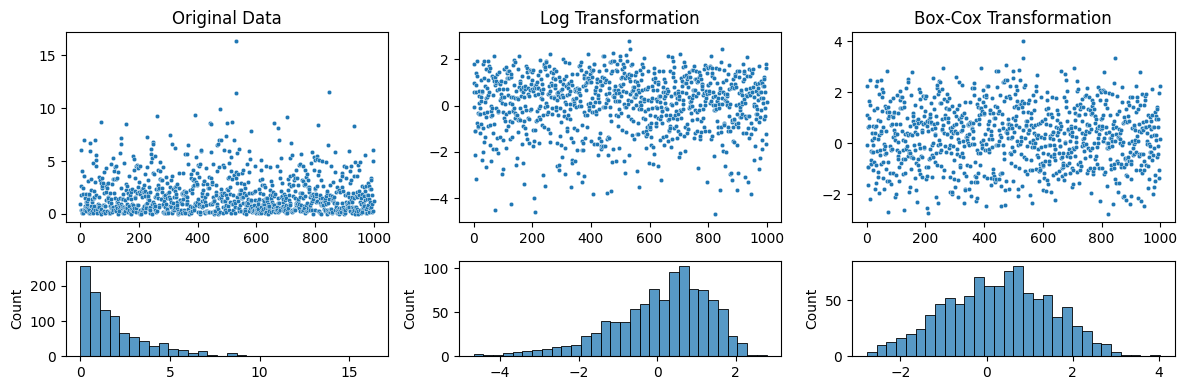

In [36]:
from scipy import stats

np.random.seed(42)
data = np.random.exponential(scale=2, size=1000)

plt.figure(figsize=(12, 4))
gs = plt.GridSpec(2, 3, height_ratios=[2, 1])

plt.subplot(gs[0, 0])
sns.scatterplot(x=np.arange(len(data)), y=data, s=10)
plt.title("Original Data")
plt.subplot(gs[1, 0])
sns.histplot(data, bins=30)

data_log = np.log(data)
plt.subplot(gs[0, 1])
sns.scatterplot(x=np.arange(len(data_log)), y=data_log, s=10)
plt.title("Log Transformation")
plt.subplot(gs[1, 1])
sns.histplot(data_log, bins=30)

data_boxcox, _ = stats.boxcox(data)
plt.subplot(gs[0, 2])
sns.scatterplot(x=np.arange(len(data_boxcox)), y=data_boxcox, s=10)
plt.title("Box-Cox Transformation")
plt.subplot(gs[1, 2])
sns.histplot(data_boxcox, bins=30)

plt.tight_layout()
plt.show()

### Работа с пропущенными значениями

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/decision_tree_and_nan_values_in_data.png" width="1000"></center>

Со всеми признаками производятся математические операции, поэтому для большинства моделей (деревья решений могут работать с пропущенными значениями, [Meaning of Surrogate Split ✏️[blog]](https://stats.stackexchange.com/questions/171574/meaning-of-surrogate-split)) отсутствие значений просто не дает производить эти операции.

Есть два основных подхода для работы с пропущенными значениями:

 1. Удалить все объекты с пропущенными значениями.
 2. На место пропущенных значений записать какие-то числа (заполнить пропущенные значения).

Иногда мы можем просто удалить объекты с пропущенными значениями, но если у нас мало данных и получение большего количества данных дорого/долго/невозможно, то нам нужно заполнить пропуски какими-то значениями.

Существует много способов заполнения пропусков значениями.

Рассмотрим наиболее популярные:

* **Заполнить константой.** Можно предположить, что данные несложные, а признаки не зависят друг от друга, и заполнить пропущенные значения средними значениями соответствующего признака.
Например, если средний возраст людей — 30 лет, то для людей, чей возраст неизвестен, будем писать это же значение. Но в некоторых ситуациях такое заполнение может только навредить.

* **Предсказывать признаки моделью.** Используем признак с пропущенными значениями как целевую переменную и на основе других заполненных признаков предсказываем пропущенные значения. Можем использовать алгоритм, который умеет справляться с пропусками. Один из таких алгоритмов — k-NN. Можно брать ближайших соседей по известным признакам и на место неизвестного признака подставлять среднее значение соседей.

* **Самостоятельно придумывать логику заполнения.** Если мы имеем экспертное знание о природе пропусков, можем сами написать логику заполнения какими-то значениями.

В датасете Titanic остался важный признак Age, который имеет пропуски. Посмотрим, как он связан с выживаемостью.

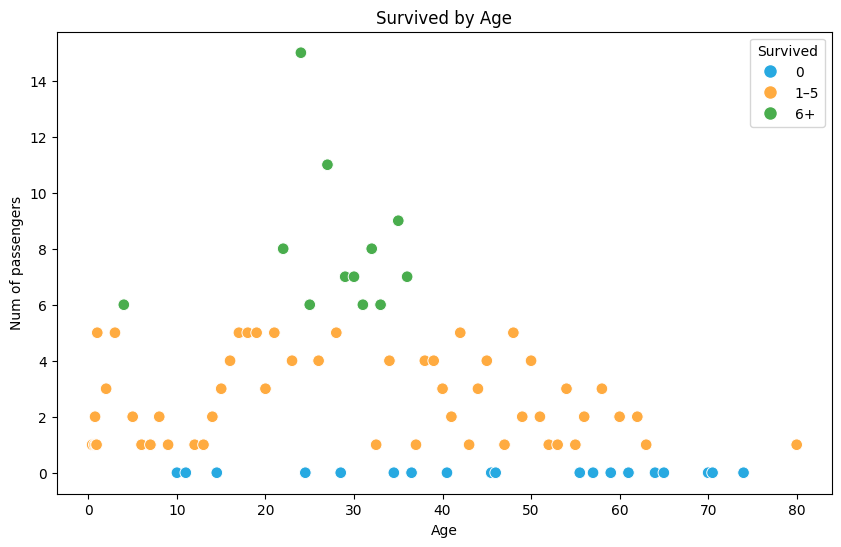

In [37]:
train_df = x_train.copy()
train_df["Survived"] = y_train

plt.figure(figsize=(10, 6))
age_survival_plot = sns.scatterplot(
    data=train_df.groupby(["Age"], as_index=False)["Survived"].agg("sum"),
    x="Age",
    y="Survived",
    hue="Survived",
    s=70,
    palette={
        0: "#27a9e1",
        1: "#ffab40",
        2: "#ffab40",
        3: "#ffab40",
        4: "#ffab40",
        5: "#ffab40",
        6: "#49AD4D",
        7: "#49AD4D",
        8: "#49AD4D",
        9: "#49AD4D",
        11: "#49AD4D",
        15: "#49AD4D",
    },
)

age_survival_plot.set_title("Survived by Age")
age_survival_plot.set_xlabel("Age")
age_survival_plot.set_ylabel("Num of passengers")
custom_legend = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10)
    for color in ["#27a9e1", "#ffab40", "#49AD4D"]
]
age_survival_plot.legend(
    custom_legend, ["0", "1–5", "6+"], title="Survived", loc="upper right"
)

plt.show()

Видим, что связь есть. Обучим модель без этого признака и посмотрим на результат:

In [38]:
x_train_working.head(3)

,SibSp,Parch,Fare,Pclass,Sex,Embarked,Title
331,0,0,28.500,1,1,0,4.0
733,0,0,13.000,2,1,0,4.0
382,0,0,7.925,3,1,0,4.0


In [39]:
results = dict()
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

results["no feature"] = round(accuracy_score(y_test, y_pred), 3)

print(f"Accuracy without feature 'Age': {results['no feature']}")

Accuracy without feature 'Age': 0.816


Заполним пропуски своей эвристикой. Вспомним, что в поле Title зашита общая информация о возрасте, посчитаем матожидание и дисперсию возраста для Title и сгенерируем недостающие значения.

In [40]:
np.random.seed(42)

train_df = x_train.copy()
train_df["Title"] = x_train_working["Title"]

mean = {}
std = {}
for title in range(5):
    data = train_df.loc[train_df["Title"] == title]
    mean[title] = data["Age"].mean()
    std[title] = data["Age"].std()


def add_age_val(data, mean, std):
    for i, row in data.iterrows():
        if np.isnan(row["Age"]):
            title = int(row["Title"])
            data.loc[i, "Age"] = round(
                np.random.uniform(
                    low=int(mean[title] - std[title]),
                    high=int(mean[title] + std[title]),
                ),
                1,
            )
    return data

In [41]:
x_train_working["Age"] = x_train["Age"]
x_test_working["Age"] = x_test["Age"]

x_train_working = add_age_val(x_train_working, mean, std)
x_test_working = add_age_val(x_test_working, mean, std)

x_train_working[:5]

,SibSp,Parch,Fare,Pclass,Sex,Embarked,Title,Age
331,0,0,28.5000,1,1,0,4.0,45.5
733,0,0,13.0000,2,1,0,4.0,23.0
382,0,0,7.9250,3,1,0,4.0,32.0
704,1,0,7.8542,3,1,0,4.0,26.0
813,4,2,31.2750,3,0,0,3.0,6.0


Посмотрим, что получилось на обработанных данных.

In [42]:
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

results["by title"] = round(accuracy_score(y_test, y_pred), 3)

print(f"Accuracy with hand-filled feature 'Age': {results['by title']}")

Accuracy with hand-filled feature 'Age': 0.821


Стало лучше. Теперь заполним пропуски с помощью модели. Воспользуемся `IterativeImputer` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) из `sklearn.impute` [🛠️[doc]](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute).

`IterativeImputer` автоматически заполняет пропущенные значения признаков, оценивая их при помощи модели. По умолчанию используется модель `BayesianRidge` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge).

In [43]:
x_train_working["Age"] = x_train["Age"]
x_test_working["Age"] = x_test["Age"]

In [44]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
imputer.fit(x_train_working)

x_train_working = imputer.transform(x_train_working)
x_test_working = imputer.transform(x_test_working)

In [45]:
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

results["imputer"] = round(accuracy_score(y_test, y_pred), 3)

print(f"Accuracy with feature 'Age' filled with IterativeImputer: {results['imputer']}")

Accuracy with feature 'Age' filled with IterativeImputer: 0.832


Сравним результаты при разном заполнении пропусков:

In [46]:
pd.DataFrame([results], index=["accuracy"])

,no feature,by title,imputer
accuracy,0.816,0.821,0.832


В нашем случае `IterativeImputer` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) дал наилучший результат. Хорошая практика — использовать данный метод как быстрый бейзлайн по заполнению пропусков.

Важно помнить, что пропуски в данных не всегда являются отсутствием значений, иногда пропуски могут быть обозначены совершенно разными способами: `0`, `-`, `(пусто)`, `'отсутствует'`, `None`, `nan`, и другие. Поэтому нужно приводить пропуски к единому формату, с которым удобно работать в дальнейшем, например `np.nan`.

# Разведочный анализ данных

Разведочный анализ данных (exploratory data analysis, EDA) — это процесс изучения данных с целью понимания их свойств. Его используют для поиска закономерностей, нахождения аномалий, создания новых признаков.

Это творческий процесс, и не существует единого рецепта, как это делать. Более того, разбору одной задачи можно посвятить лекцию. Наша задача в этом блоке — познакомиться с основными инструментами для анализа.

Будем работать с датасетом [Wine Quality 🛠️[doc]](https://archive.ics.uci.edu/dataset/186/wine+quality) по определению цвета вина в зависимости от его характеристик.

Загрузим датасет и сразу посмотрим, как он выглядит:

In [115]:
import pandas as pd

dataset = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/wine_quality_data.csv"
)
dataset

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


Можем сделать первые выводы об объеме датасета и количестве признаков.

## Описательные статистики

Теперь посмотрим более детально, используя встроенные методы `pandas`:

In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  is_red                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


Видим, что нет пропусков. Смотрим, все ли признаки соответствуют своему `Dtype`, также можем оценить размер используемой памяти.

Посмотрим описательные статистики по признакам:

In [49]:
dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Чтобы стало нагляднее, можем использовать `DataFrame.hist` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) прямо из `pandas`:

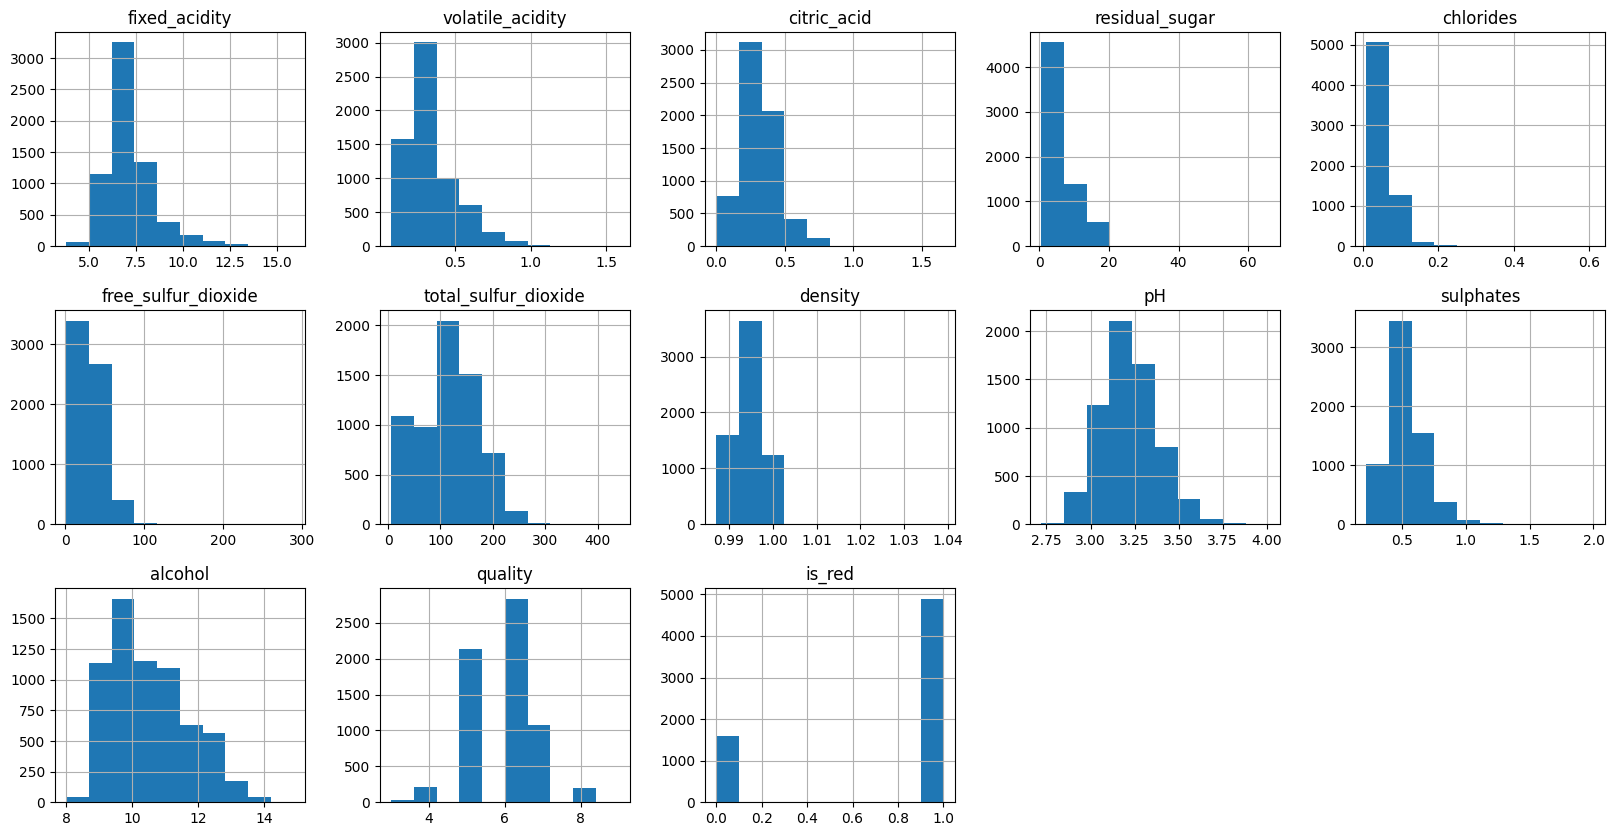

In [50]:
import matplotlib.pyplot as plt

dataset.hist(figsize=(20, 10), layout=(-1, 5))
plt.show()

Видим, что у нас присутствует дисбаланс классов (распределение целевого признака `is_red`). Почти все распределения признаков одномодальные. Можем оценить диапазон значений признаков.

## Взаимодействие признаков

Полезно знать, как признаки взаимодействуют друг с другом и с целевой переменной. Часто для первичной оценки используют корреляцию. Дополнительно это поможет нам найти в датасете скоррелированные признаки. Для этого воспользуемся `DataFrame.corr` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) и `seaborn.heatmap` [🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

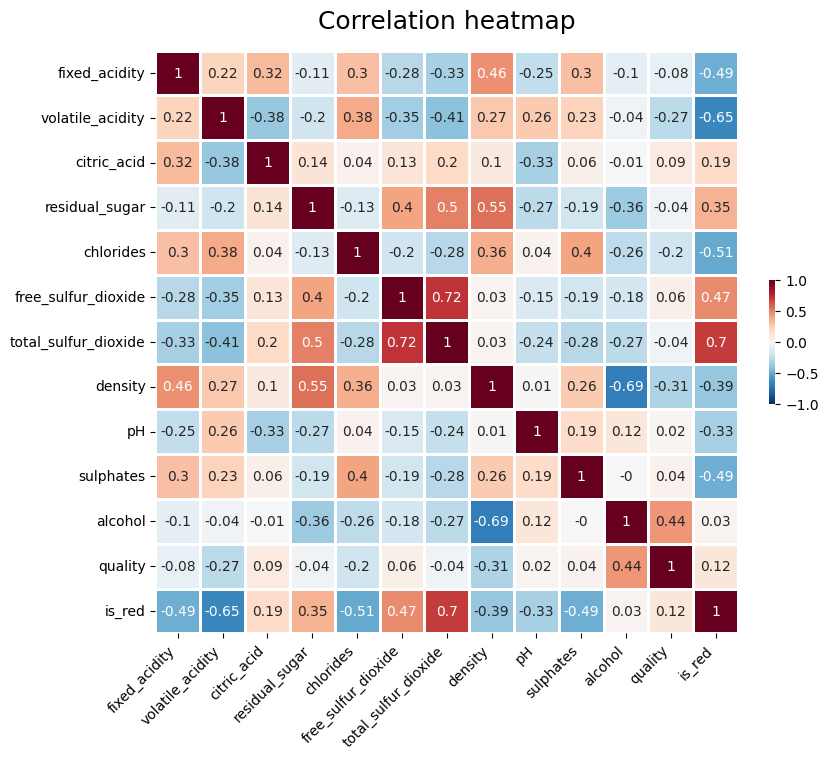

In [51]:
import seaborn as sns

plt.figure(figsize=(8, 8))

heatmap = sns.heatmap(
    dataset.corr(method="pearson", numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="RdBu_r",
    vmax=1,
    vmin=-1,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Correlation heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

Видим, что два признака имеют высокую корреляцию между собой (`free_sulfur_dioxide` и `total_sulfur_dioxide`). [Почему это плохо и что с этим делать ✏️[blog]](https://habr.com/ru/companies/akbarsdigital/articles/592493/).

Также важно отметить, что корреляция Пирсона, посчитанная для категориальных признаков, может давать некорректные и бессмысленные результаты.

Поэтому на практике хорошо себя показывает [Phi_K 🛠️[doc]](https://phik.readthedocs.io/en/latest/) ($\phi_k$) корреляция. Она, в отличие от корреляции Пирсона, учитывает нелинейные зависимости и работает с категориальными признаками.

In [52]:
!pip install -q phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 12.0 MB/s eta 0:00:00


В этот раз отсортируем коэффициенты корреляции по целевой переменной:

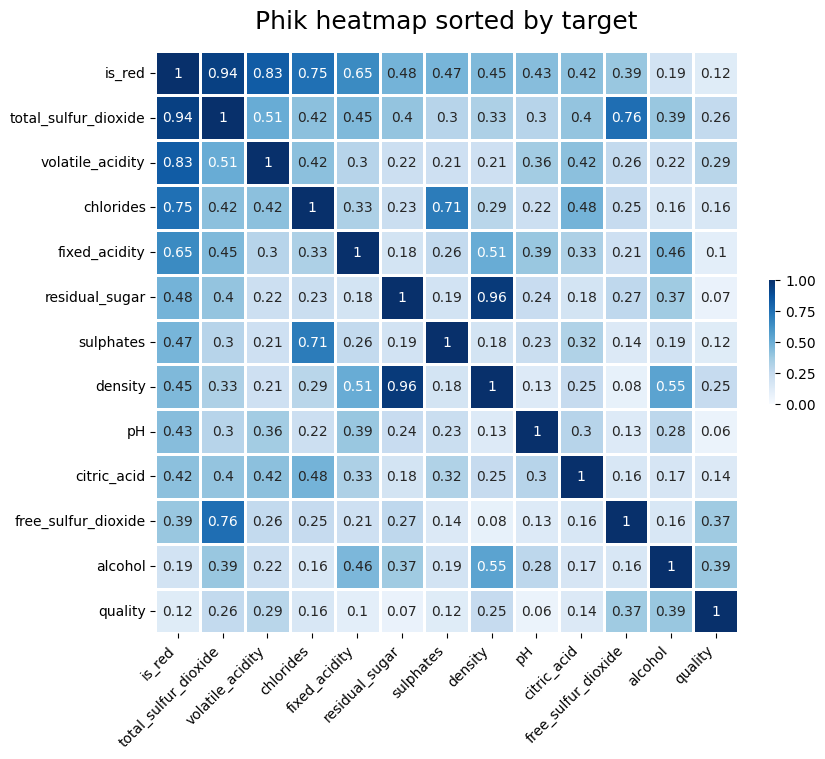

In [53]:
import phik

plt.figure(figsize=(8, 8))

sotred_columns = (
    dataset.phik_matrix(interval_cols=dataset.columns)
    .round(2)
    .sort_values("is_red", ascending=False, axis=1)
    .columns
)

heatmap = sns.heatmap(
    dataset.phik_matrix(interval_cols=dataset.columns)
    .round(2)
    .sort_values("is_red", ascending=False, axis=1)
    .reindex(sotred_columns),
    annot=True,
    square=True,
    cmap="Blues",
    vmax=1,
    vmin=0,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Phik heatmap sorted by target", fontdict={"fontsize": 18}, pad=16)
plt.show()

Можем выделить признаки, которые имеют наибольший коэффициент. Посмотрим, как они взаимодействуют друг с другом.

При большом количестве объектов бывает сложно понять, какие есть зависимости (объекты накладываются друг на друга), поэтому мы возьмем случайные 1000 объектов из датасета, чтобы было нагляднее. Воспользуемся `seaborn.pairplot` [🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.pairplot.html).

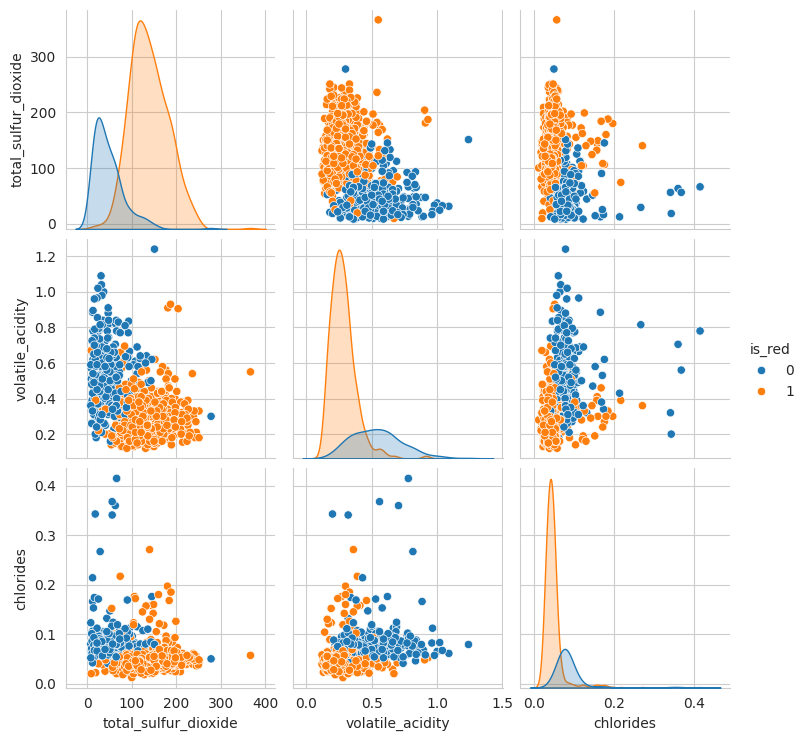

In [54]:
sns.set_style("whitegrid")

sns.pairplot(
    dataset.sample(1000),
    vars=["total_sulfur_dioxide", "volatile_acidity", "chlorides"],
    hue="is_red",
)
plt.show()

Можем отметить, что признак `total_sulfur_dioxide` действительно хорошо разделяется по целевому признаку. Также хорошее разделение видим в паре признаков `total_sulfur_dioxide` и `volatile_acidity`.

## Анализ категориальных признаков

В датасете есть категориальный признак `quality`. Посмотрим, как распределен `total_sulfur_dioxide` в разрезе по целевому признаку и по каждому значению `quality`:

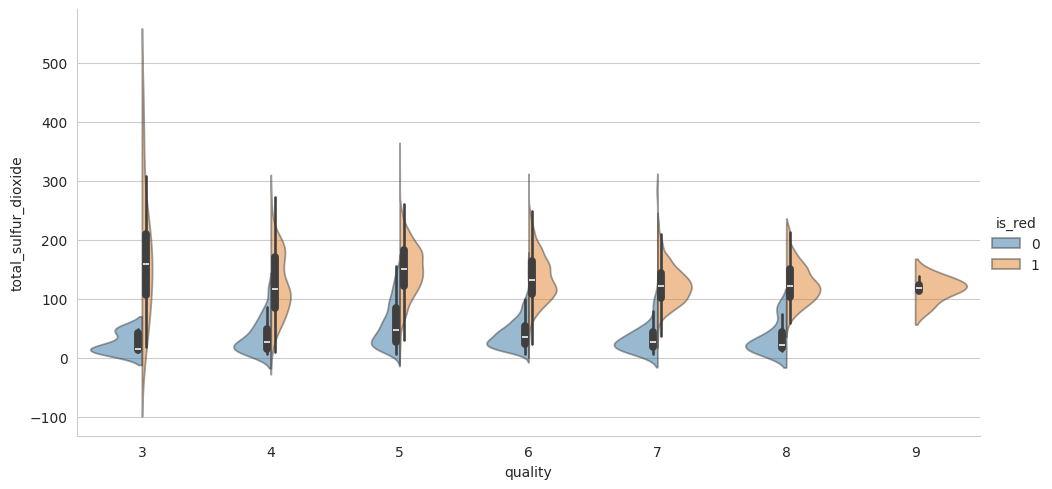

In [55]:
sns.catplot(
    data=dataset,
    x="quality",
    y="total_sulfur_dioxide",
    hue="is_red",
    aspect=2,
    alpha=0.5,
    kind="violin",  # strip, swarm, box, violin, boxen, point, bar, or count
    split=True,
)
plt.show()

Видим, что в 9 категории нет объектов другого класса, но такой график не отражает количество объектов в категориях. Можем это посмотреть, воспользовавшись `pandas.crosstab` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html):

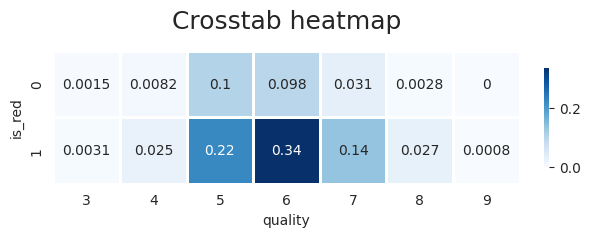

In [56]:
cross_tab = sns.heatmap(
    pd.crosstab(dataset["is_red"], dataset["quality"], normalize=True).round(4),
    annot=True,
    square=True,
    cmap="Blues",
    cbar_kws={"fraction": 0.01},
    linewidth=1,
)

cross_tab.set_title("Crosstab heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

Теперь видно, что объектов 9 категории довольно мало. Также можем оценить, в каких категориях сконцетрированы объекты.

Еще один полезный тип графика — это `seaborn.relplot` [🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.relplot.html). Eго удобно использовать, если у нас есть временной признак, тогда мы можем построить зависимость признака относительно времени.

У нас такого признака нет. Построим два признака с раскраской по категориальной переменной `quality`:

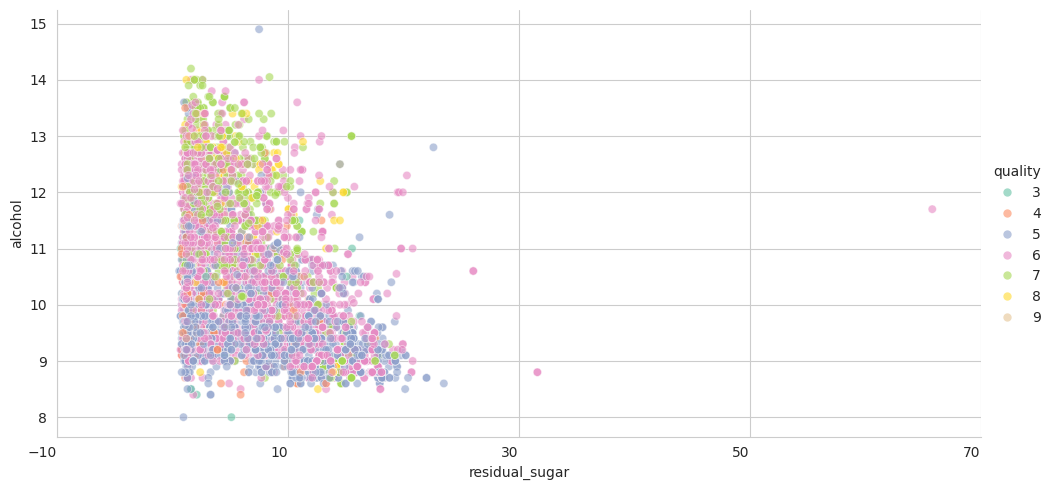

In [57]:
relplot = sns.relplot(
    data=dataset,
    x="residual_sugar",
    y="alcohol",
    hue="quality",
    kind="scatter",  # or line
    aspect=2,
    alpha=0.6,
    palette="Set2",
)

relplot.set_xticklabels(horizontalalignment="right", step=2)
plt.show()

Видно, что объекты 5 категории в среднем находятся ниже 7 категории. Построим тот же `seaborn.relplot`, но уже для двух категорий. В этот раз для примера будем использовать параметр `kind="line"`, который отвечает за вид графика:

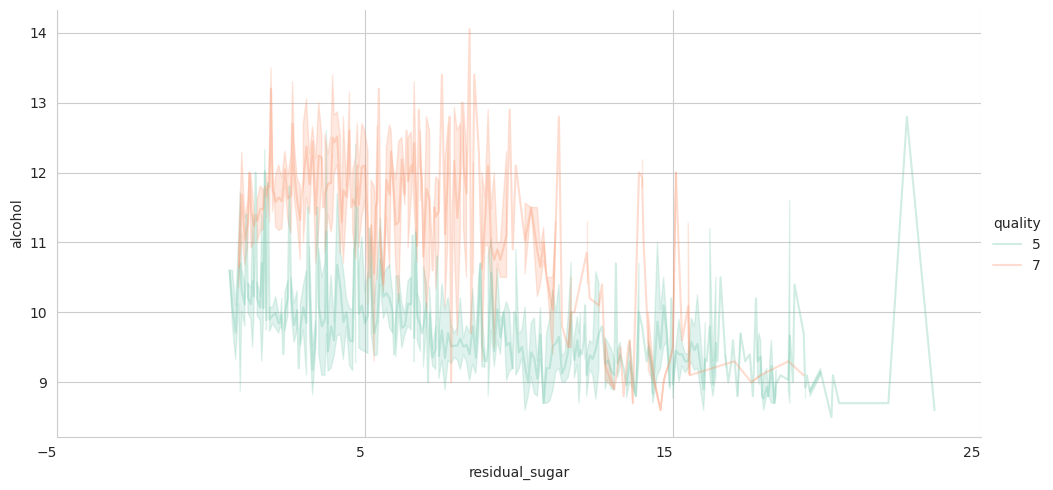

In [58]:
relplot = sns.relplot(
    data=dataset.query("quality == (5,7)"),
    x="residual_sugar",
    y="alcohol",
    hue="quality",
    kind="line",
    aspect=2,
    alpha=0.3,
    palette="Set2",
)

relplot.set_xticklabels(horizontalalignment="right", step=2)
plt.show()

Итоги:
* Способов визуализации данных довольно много, запомните несколько и научитесь ими пользоваться. Например, те, которые мы рассмотрели в лекции.
* Раскрашивайте объекты не только по целевому признаку, но и по категориальным.
* Для анализа трендов стройте график по времени, частоте или другому признаку.
* Если объектов много, то стройте несколько графиков только на подвыборке объектов.


[[git] 🐾 Пример EDA](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb)

[[blog] ✏️ Примеры графиков matplotlib](https://habr.com/ru/articles/468295/)

[[video] 📺 Курс лекций с разбором практических задач с применением EDA](https://www.youtube.com/watch?v=FNDQYM0hjh0&list=PLaRUeIuewv8CMFox0oEjlyePUhUmo-x0h)

# Генерация признаков


Общая схема классического машинного обучения выглядит так. Даже в случае нейросетей некоторая предобработка исходных данных все равно не бывает лишней.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/data_preparation.png" width="600"></center>



**Генерация признаков** &mdash; процесс создания числовых представлений данных.







Процесс создания признаков зависит от модели, которую мы собираемся использовать.

Для одних моделей (**линейные, древесные модели**) может быть полезно добавить признаки, полученные **делением/перемножением** исходных. Другие модели (например, **SVM**) могут провести эти операции сами, причем, экономнее/менее переобучаясь.

Добавление признаков, явно зависящих друг от друга, мешает некоторым моделям. Например, плохая идея — дублировать в линейной модели признаки X1 и X2 или добавлять их сумму.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/process_of_generation_features.png" width="700"></center>

**Feature engineering** является критическим местом (**bottleneck**) в машинном обучении. На этом этапе определяется, **что модель будет знать о данных**. Можно упростить задачу для модели, подав подходящий набор признаков, или ввести модель в заблуждение, допустив критические ошибки.

ML-модели “ленивы”: если дать модели **подсказку** об ответе, она **не будет искать сложные закономерности в данных**. Такой подсказкой может быть **id покупателя**. Для покупателя, который каждую неделю покупает одно и то же, модель выучит, что надо предсказывать все по признаку id. Если покупатель изменит свое поведение или придет новый покупатель, то модель может выдавать неадекватные предсказания. Такую же роль может сыграть информация о **номере эксперимента**, **лаборатории**, в которой его проводили, **аспиранте**, который его проводил, и т.д. Эта ситуация будет называться **Data Leakage**.
Перечисленная выше информация может быть важна для **анализа исходных данных**, например, можно выяснить, что у прибора в лаборатории А проблемы с калибровкой.

## Baseline

При решении задачи машинного обучения важно оценивать результат. Один из способов оценить результат — это сделать базовое решение задачи. Как правило, это решение, которое требует мало времени для реализации и явно лучше случайного ответа. Далее, улучшая решение, мы можем понять, насколько оно лучше базового и что на это повлияло (подбор гиперпараметров, кодирование признаков, генерация признаков и многое другое).

Постановка задачи следующая:

Автомобильная компания выходит на новый рынок. После интенсивного исследования рынка они пришли к выводу, что поведение нового рынка похоже на их существующий рынок. На существующем рынке отдел продаж, изучив поведение клиентов, разделил их на сегменты (классы) A, B, C, D. Для нового рынка данных о поведении нет, но есть данные о потенциальных клиентах (пол, возраст, образование, уровень дохода, состав семьи и т.д.). Нужно классифицировать потенциальных клиентов.



Загрузим [датасет 🛠️[doc]](https://www.kaggle.com/code/iamhungundji/customer-segmentation/input) и посмотрим, какие есть признаки:

In [116]:
import pandas as pd

data = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/customer_segmentation.csv"
)
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Посмотрим признак `Family_Size`. По смыслу он не подразумевает вещественных значений, хотя хранится в формате `float64`:

In [61]:
data["Family_Size"].unique()

array([ 4.,  3.,  1.,  2.,  6., nan,  5.,  8.,  7.,  9.])

Действительно, все значения целые. В нашем случае не критично, но если датасет большой, то имеет смысл привести формат данных к более компактному представлению.

Видно, что есть пропуски. Для базового решения можно удалить или заполнить нулями. Мы заполним нулями и переведем все категориальные признаки в формат one-hot encoding:

In [62]:
from sklearn.model_selection import train_test_split


data["Segmentation"] = data["Segmentation"].map({"D": 1, "A": 2, "C": 3, "B": 4})
data.fillna(0, inplace=True)
data.drop(columns=["ID"], inplace=True)
data = pd.get_dummies(data)  # to ohe

x = data.drop(columns=["Segmentation"], axis=1)
y = data["Segmentation"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (5647, 32)
Shape of y_train : (5647,)
Shape of x_test : (2421, 32)
Shape of y_test : (2421,)


Запустим модель случайного леса и посмотрим, какой результат получится:

Training Accuracy:  0.966
Testing Accuracy:  0.491
              precision    recall  f1-score   support

           1       0.62      0.71      0.66       692
           2       0.41      0.38      0.39       597
           3       0.50      0.49      0.49       580
           4       0.37      0.35      0.36       552

    accuracy                           0.49      2421
   macro avg       0.48      0.48      0.48      2421
weighted avg       0.48      0.49      0.49      2421



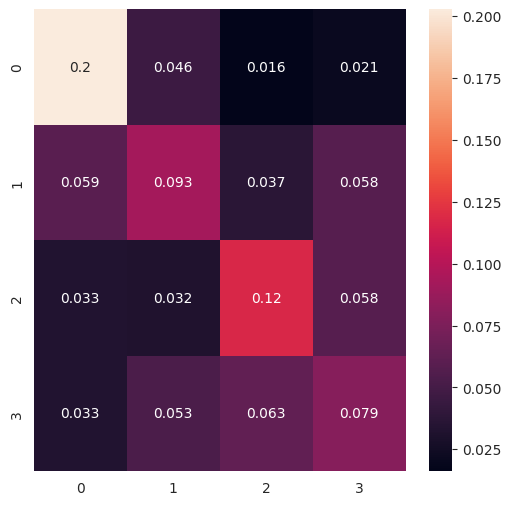

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


def train_and_plot(x_train, y_train, x_test, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    # evaluating the model
    print("Training Accuracy: ", round(model.score(x_train, y_train), 3))
    print("Testing Accuracy: ", round(model.score(x_test, y_test), 3))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="all")
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True)

    # classification report
    cr = classification_report(y_test, y_pred)
    print(cr)


train_and_plot(x_train, y_train, x_test, y_test)

Получили быстрое решение и посчитали метрики. Это будет baseline, и наша следующая задача — улучшить это решение.

## Генерация признаков, полученных при помощи другой модели

Мы можем использовать другие модели, чтобы получить новые признаки для наших данных. Например, используя разные модели, можем использовать их предсказания как новые признаки. В каком-то смысле мы это уже делали на прошлой лекции, разбирая блендинг.

**Генерация бинарного признакового пространства с помощью RandomForest:**

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/generating_features_using_model.png" width="700"></center>

[[colab] 🥨 Генерация признаков с использованием RandomForest и GradientBoosting ](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Classic_ML/feature_generation_rf_gb.ipynb)

### IsolationForest

Добавим новый бинарный признак, используя `IsolationForest`:

In [64]:
from sklearn.ensemble import IsolationForest

n_estimators = 300
# contamination is a threshold for Isolation Forest
model = IsolationForest(
    n_estimators=n_estimators, contamination="auto", random_state=42
)
model.fit(x_train)
x_train["new_feature_1"] = model.predict(x_train)
x_test["new_feature_1"] = model.predict(x_test)

Обратите внимание, что при генерации новых признаков важно не переобучиться и не допустить утечку данных, поэтому мы обучаем `IsolationForest` на train, а не на всей выборке.

Training Accuracy:  0.966
Testing Accuracy:  0.494
              precision    recall  f1-score   support

           1       0.62      0.71      0.66       692
           2       0.42      0.39      0.40       597
           3       0.51      0.49      0.50       580
           4       0.36      0.34      0.35       552

    accuracy                           0.49      2421
   macro avg       0.48      0.48      0.48      2421
weighted avg       0.49      0.49      0.49      2421



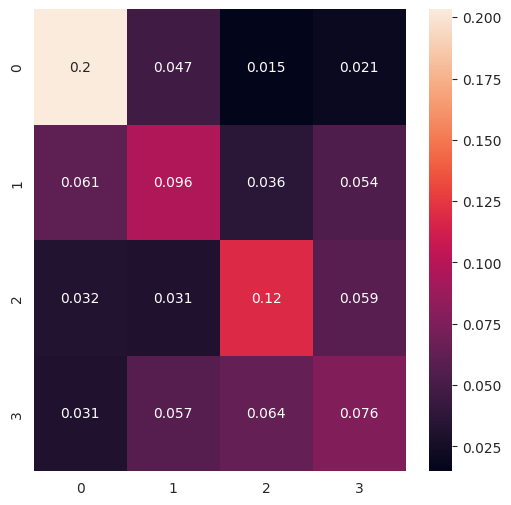

In [65]:
train_and_plot(x_train, y_train, x_test, y_test)

Качество немного улучшилось.

### K-Means

Можем использовать алгоритмы кластеризации, чтобы получить новые признаки. Количество кластеров можно подбирать, оно не всегда должно быть равно количеству классов. Для примера возьмем `n_clusters=12`.

In [66]:
import sklearn.cluster as cluster

clusters = cluster.KMeans(n_clusters=12, n_init="auto", random_state=42).fit(x_train)

x_train["new_feature_2"] = clusters.predict(x_train)
x_test["new_feature_2"] = clusters.predict(x_test)
x_train.head(3)

,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_0,Ever_Married_No,Ever_Married_Yes,Graduated_0,Graduated_No,...,Var_1_0,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,new_feature_1,new_feature_2
5015,49,1.0,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,1,2
5755,87,0.0,2.0,False,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,1,7
7781,28,8.0,3.0,True,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,1,0


Training Accuracy:  0.966
Testing Accuracy:  0.504
              precision    recall  f1-score   support

           1       0.62      0.70      0.66       692
           2       0.43      0.40      0.41       597
           3       0.53      0.52      0.52       580
           4       0.39      0.37      0.38       552

    accuracy                           0.50      2421
   macro avg       0.49      0.49      0.49      2421
weighted avg       0.50      0.50      0.50      2421



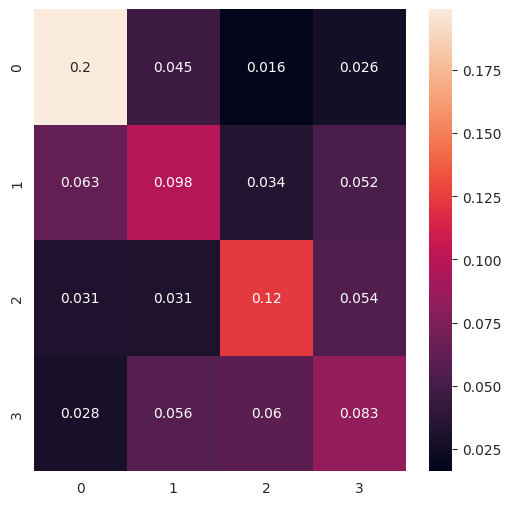

In [67]:
train_and_plot(x_train, y_train, x_test, y_test)

## Ручная генерация признаков

Можем генерировать признаки самостоятельно, придумывая различные гипотезы и эвристики. Это творческий процесс, и нет точного рецепта, какие признаки стоит сгенерировать. Также генерация признаков зависит от модели, для которой эти признаки генерируем. Например, признаки, описывающие нелинейное взаимодействие, могут кардинально изменить качество линейной модели.

Наша задача — рассмотреть инструменты для генерации признаков.

In [68]:
data = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/customer_segmentation.csv"
)
data.dropna(inplace=True)
data.head(3)

В этот раз закодируем признаки по их присутствию в данных:

In [70]:
data["Profession"].value_counts()

,count
Profession,
Artist,2192
Healthcare,1077
Entertainment,809
Doctor,592
Engineer,582
Executive,505
Lawyer,500
Marketing,233
Homemaker,175


In [71]:
data["Gender"] = data["Gender"].map({"Male": 1, "Female": 0})

data["Graduated"] = data["Graduated"].map({"Yes": 1, "No": 0})

data["Ever_Married"] = data["Ever_Married"].map({"Yes": 1, "No": 0})

data["Spending_Score"] = data["Spending_Score"].map({"High": 1, "Average": 2, "Low": 3})

data["Var_1"] = data["Var_1"].map(
    {"Cat_6": 1, "Cat_4": 2, "Cat_3": 3, "Cat_2": 4, "Cat_7": 5, "Cat_1": 6, "Cat_5": 7}
)

data["Segmentation"] = data["Segmentation"].map({"D": 1, "A": 2, "C": 3, "B": 4})

data["Profession"] = data["Profession"].map(
    {
        "Artist": 1,
        "Healthcare": 2,
        "Entertainment": 3,
        "Doctor": 4,
        "Engineer": 5,
        "Executive": 5,
        "Lawyer": 6,
        "Marketing": 7,
        "Homemaker": 8,
    }
)
data.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0,22,0,2,1.0,3,4.0,2,1
2,466315,0,1,67,1,5,1.0,3,1.0,1,4
3,461735,1,1,67,1,6,0.0,1,2.0,1,4
5,461319,1,1,56,0,1,0.0,2,2.0,1,3
6,460156,1,0,32,1,2,1.0,3,3.0,1,3


Можем производить различные математические операции с признаками: перемножать, делить, складывать и т.д. Для временных рядов полезно брать производные, считать стандартное отклонение и т.д.

Для примера перемножим признаки `Age` и `Work_Experience`:

In [72]:
data["new_feature_1"] = data["Age"] * data["Work_Experience"]
data.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,new_feature_1
0,462809,1,0,22,0,2,1.0,3,4.0,2,1,22.0
2,466315,0,1,67,1,5,1.0,3,1.0,1,4,67.0
3,461735,1,1,67,1,6,0.0,1,2.0,1,4,0.0


Полезный метод для генерации признаков — это `pd.groupby` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

Посчитаем средний возраст для каждой профессии и опыта работы:

In [73]:
data["new_feature_2"] = data.groupby(["Profession", "Work_Experience"], as_index=False)[
    "Age"
].transform("mean")
data.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,new_feature_1,new_feature_2
0,462809,1,0,22,0,2,1.0,3,4.0,2,1,22.0,26.739255
2,466315,0,1,67,1,5,1.0,3,1.0,1,4,67.0,48.608466
3,461735,1,1,67,1,6,0.0,1,2.0,1,4,0.0,75.520548


Можно использовать разные функции. Например, медиану:

In [74]:
data["new_feature_3"] = data.groupby(["Spending_Score", "Family_Size"], as_index=False)[
    "Var_1"
].transform("median")
data.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,new_feature_1,new_feature_2,new_feature_3
0,462809,1,0,22,0,2,1.0,3,4.0,2,1,22.0,26.739255,1.0
2,466315,0,1,67,1,5,1.0,3,1.0,1,4,67.0,48.608466,1.0
3,461735,1,1,67,1,6,0.0,1,2.0,1,4,0.0,75.520548,1.0


Также можем написать свою функции и использовать ее:

In [75]:
import numpy as np

custom_func = lambda x: np.percentile(x, 75)
data["new_feature_4"] = data.groupby(["Spending_Score", "Family_Size"], as_index=False)[
    "Age"
].transform(custom_func)
data.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,new_feature_1,new_feature_2,new_feature_3,new_feature_4
0,462809,1,0,22,0,2,1.0,3,4.0,2,1,22.0,26.739255,1.0,32.0
2,466315,0,1,67,1,5,1.0,3,1.0,1,4,67.0,48.608466,1.0,57.0
3,461735,1,1,67,1,6,0.0,1,2.0,1,4,0.0,75.520548,1.0,79.0


Можем сгенерировать новую таблицу признаков, используя `pivot_table` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html):


```python
data.pivot_table(
    index="index",
    columns=["columns"],  
    values=["values"],  
    aggfunc=["mean"],  
)
```


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/pivot_table.png" width="700"></center>

In [76]:
data_pivot = data.pivot_table(
    index="Family_Size",  # indexes
    columns=["Var_1"],  # new columns
    values=["Age"],  # values are used fo aggfunc
    aggfunc=["mean", "count"],  # mean/count/sum
).fillna(0)

data_pivot.columns = [f"Cat{int(i[2])}_{i[0]}" for i in data_pivot.columns]
data_pivot.reset_index(inplace=True)

data_pivot.head(3)

,Family_Size,Cat1_mean,Cat2_mean,Cat3_mean,Cat4_mean,Cat5_mean,Cat6_mean,Cat7_mean,Cat1_count,Cat2_count,Cat3_count,Cat4_count,Cat5_count,Cat6_count,Cat7_count
0,1.0,49.434354,44.256637,46.272000,41.333333,40.041667,44.230769,42.777778,914.0,113.0,125.0,45.0,24.0,13.0,9.0
1,2.0,51.064619,43.015625,39.494048,45.171053,44.159091,42.187500,40.888889,1563.0,192.0,168.0,76.0,44.0,32.0,18.0
2,3.0,42.033257,38.161290,36.627907,36.263889,37.935484,34.476190,36.333333,872.0,155.0,129.0,72.0,31.0,21.0,12.0


А потом соединить ее с исходной:

In [77]:
data = data.merge(data_pivot, how="inner", on="Family_Size")
data.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Cat5_mean,Cat6_mean,Cat7_mean,Cat1_count,Cat2_count,Cat3_count,Cat4_count,Cat5_count,Cat6_count,Cat7_count
0,462809,1,0,22,0,2,1.0,3,4.0,2,...,37.114286,39.047619,39.230769,726.0,158.0,132.0,89.0,35.0,21.0,13.0
1,466315,0,1,67,1,5,1.0,3,1.0,1,...,40.041667,44.230769,42.777778,914.0,113.0,125.0,45.0,24.0,13.0,9.0
2,461735,1,1,67,1,6,0.0,1,2.0,1,...,44.159091,42.187500,40.888889,1563.0,192.0,168.0,76.0,44.0,32.0,18.0


Мы довольно быстро увеличили количество признаков в нашем датасете. Проверим, как это повлияло на качество:

In [78]:
data.drop(columns=["ID"], inplace=True)

x = data.drop(columns=["Segmentation"], axis=1)
y = data["Segmentation"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (4665, 27)
Shape of y_train : (4665,)
Shape of x_test : (2000, 27)
Shape of y_test : (2000,)


Training Accuracy:  0.965
Testing Accuracy:  0.486
              precision    recall  f1-score   support

           1       0.62      0.63      0.62       548
           2       0.43      0.43      0.43       487
           3       0.51      0.52      0.52       508
           4       0.36      0.34      0.35       457

    accuracy                           0.49      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.49      0.49      2000



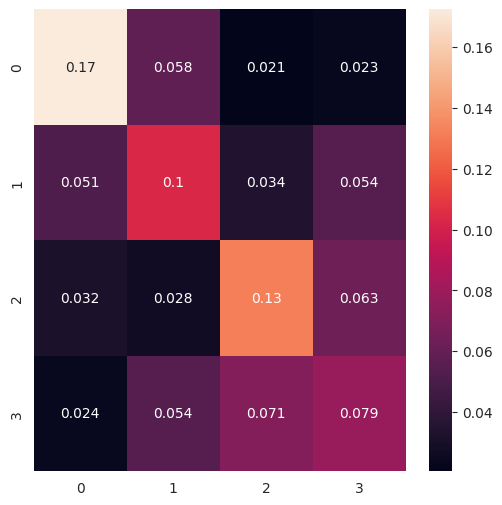

In [79]:
train_and_plot(x_train, y_train, x_test, y_test)

Стало хуже. Возможно, какие-то признаки и улучшали качество, но другие его испортили сильнее. После того, как мы нагенерировали много признаков, стоит задуматься о том, какие признаки улучшают качество, а какие его ухудшают.

# Отбор признаков

Рассмотрим способы и подходы, чтобы отделять полезные признаки от бесполезных.

## Зачем отбирать признаки

* **Количество необходимых признаков может оказаться избытычным для решения задачи**

Не всегда нужно использовать все признаки, которые у нас есть и которые мы можем нагенерировать. Нам нужны только те признаки, которые позволяют решить задачу.


* **Некоторые признаки могут оказаться шумом**

Признаки могут коррелировать с целевой переменной случайно. Если провести эксперимент и сгенерировать большое количество случайных признаков для нашего датасета, мы можем заметить эффект, что некоторые из них действительно улучшают качество предсказания, но это никак не связано с реальной закономерностью. На новых (тестовых) данных мы обнаружим неадекватность предсказаний.

В более общем случае можно говорить, что в многомерном пространстве почти всегда можно найти корреляции:

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/fake_correlations.png" alt="alttext" width="700"/></center>

<center><em>В многоразмерном пространстве почти всегда можно найти корреляции. Из корреляции не следует причинно-следственная связь.</em></center>

<center><em>Source: <a href="https://www.wnycstudios.org/podcasts/otm/articles/spurious-correlations">Deaths by Swimming Pool Drowning vs. Nicholas Cage Films and Other Spurious Correlations</a></em></center>

[[blog] ✏️ Больше подобных примеров](https://tylervigen.com/spurious-correlations)

* **Скорость работы модели часто имеет значение**

В практических задачах часто приходится искать компромисс между точностью предсказания модели и временем его получения.

Спектр таких задач достаточно широк: от проблем построения быстрых систем ранжирования рекламных объявлений в интернет-маркетинге до построения быстрых систем распознавания сложных событий на ускорителях заряженных частиц.

Вычислительная сложность модели растёт с увеличением числа входных признаков, поэтому работающие с меньшим числом признаков модели являются предпочтительными.

## Полный перебор

Можно попытаться перебрать все возможные комбинации признаков. Однако даже для 100 признаков такой подход будет считаться до конца Вселенной.

Потому прибегают к эвристикам, которые могут пропускать оптимальное решение.

## Одномерный отбор признаков

Самый простой подход к отбору признаков — это одномерный подход. В нём оценивается связь каждого признака с целевой переменной, например, измеряется корреляция.

Такой подход не учитывает сложные закономерности: в нём все признаки считаются независимыми, тогда как в машинном обучении модели учитывают взаимное влияние признаков, их пар или даже более сложные взаимодействия.

Будем использовать датасет Титаник, загрузим данные:

In [117]:
import pandas as pd

dataset = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/titanic.csv"
)
dataset.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Сделаем предобработку и кодирование признаков:

In [81]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


title_mapping = {"Mr": 4, "Miss": 3, "Mrs": 2, "Master": 1}
# get title from name and encode by title_mapping, another titles fill zero
dataset["Title"] = (
    dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    .map(title_mapping)
    .fillna(0)
)
# encode to binary column
dataset["Sex"] = dataset["Sex"].map({"male": 1, "female": 0})
# ordinary encode by values_count
dataset["Embarked"] = dataset["Embarked"].map({np.nan: 0, "S": 0, "Q": 1, "C": 2})
# parse cabin to get deck A, B, C etc
dataset["Deck"] = dataset["Cabin"].str.extract("([A-Za-z])")
# parse cabin to get cabin number
dataset["Cabin_Number"] = dataset["Cabin"].str.extract("(\d+)").astype(float).fillna(0)
# get sqrt fare
dataset["sqrt_Fare"] = np.sqrt(dataset["Fare"])
# deck encode to ohe format
deck_to_ohe = pd.get_dummies(dataset["Deck"], prefix="Cab", dummy_na=True)
# add ohe features to dataset
dataset = pd.concat([dataset, deck_to_ohe], axis=1)
# drop unnecessary columns
dataset.drop(
    columns=["Name", "Ticket", "Cabin", "PassengerId", "Deck", "Fare"], inplace=True
)
# train imputer to fill nans for age
imputer = IterativeImputer()
imputer.fit(dataset[["Age", "Title", "sqrt_Fare"]])
# fill age nans by imputer
dataset["Age"] = imputer.transform(dataset[["Age", "Title", "sqrt_Fare"]])

dataset.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_Number,sqrt_Fare,Cab_A,Cab_B,Cab_C,Cab_D,Cab_E,Cab_F,Cab_G,Cab_T,Cab_nan
0,0,3,1,22.0,1,0,0,4.0,0.0,2.692582,False,False,False,False,False,False,False,False,True
1,1,1,0,38.0,1,0,2,2.0,85.0,8.442944,False,False,True,False,False,False,False,False,False
2,1,3,0,26.0,0,0,0,3.0,0.0,2.815138,False,False,False,False,False,False,False,False,True
3,1,1,0,35.0,1,0,0,2.0,123.0,7.286975,False,False,True,False,False,False,False,False,False
4,0,3,1,35.0,0,0,0,4.0,0.0,2.837252,False,False,False,False,False,False,False,False,True


Дополнительно добавим в наш датасет случайные признаки, чтобы оценить, как методы отбора будут учитывать их:

In [82]:
from sklearn.model_selection import train_test_split

random_features = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/random_features.csv"
)
dataset = pd.concat([dataset, random_features], axis=1)

x = dataset.drop(columns=["Survived"])
y = dataset["Survived"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

dataset.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_Number,sqrt_Fare,...,Cab_E,Cab_F,Cab_G,Cab_T,Cab_nan,random_1,random_2,random_3,random_4,random_5
0,0,3,1,22.0,1,0,0,4.0,0.0,2.692582,...,False,False,False,False,True,9.4,3,1.0,2,2
1,1,1,0,38.0,1,0,2,2.0,85.0,8.442944,...,False,False,False,False,False,9.8,2,1.0,1,1
2,1,3,0,26.0,0,0,0,3.0,0.0,2.815138,...,False,False,False,False,True,9.8,3,4.0,2,2
3,1,1,0,35.0,1,0,0,2.0,123.0,7.286975,...,False,False,False,False,False,9.8,2,1.0,3,1
4,0,3,1,35.0,0,0,0,4.0,0.0,2.837252,...,False,False,False,False,True,9.4,3,3.0,2,1


Оценим, как признаки связаны с целевой переменной. Будем использовать критерий оценки взаимной информации (`mutual_info_classif` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)):

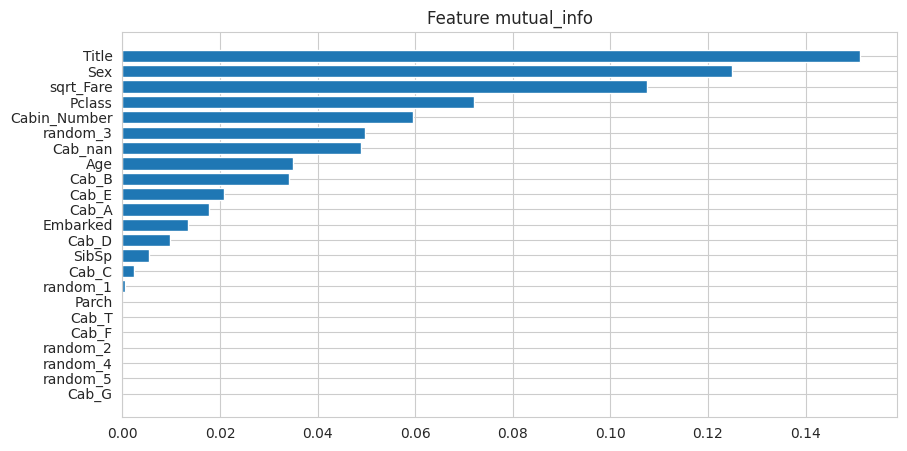

In [83]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(x_train, y_train)

df_mi = pd.DataFrame({"mi_feature": x_train.columns, "mutual_information": mi})
df_mi = df_mi.sort_values(by="mutual_information", ascending=False).reset_index(
    drop=True
)

fig = plt.figure(figsize=(10, 5))
sorted_idx = np.argsort(df_mi["mutual_information"])
plt.barh(
    range(df_mi.shape[0]), df_mi["mutual_information"].iloc[sorted_idx], align="center"
)
plt.yticks(range(df_mi.shape[0]), df_mi["mi_feature"].iloc[sorted_idx])
plt.title("Feature mutual_info")
plt.show()

Следующая идея — посчитать ROC-AUC по признаку, учитывая его как предсказание модели. Если ROC-AUC высокий (нас интересуют только абсолютные значения), то признак важный.

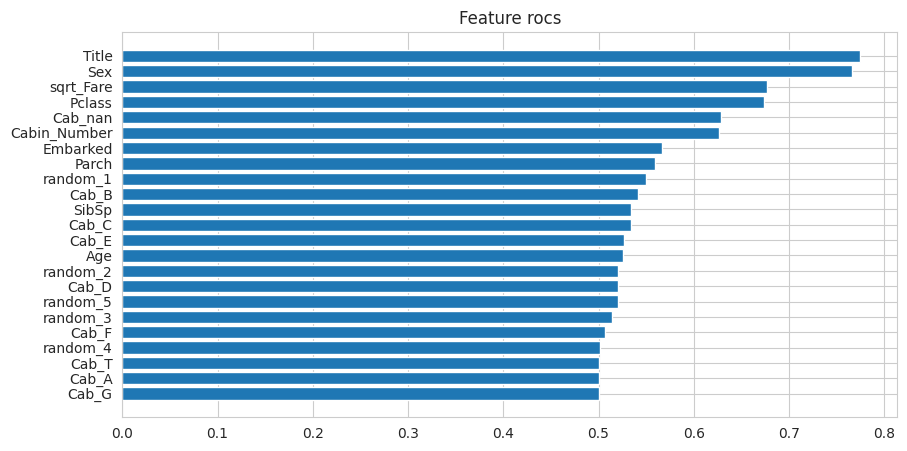

In [84]:
from sklearn.metrics import roc_auc_score


rocs = []  # create a storage for rocs
for column in x:
    # use feature as score directly
    r1 = roc_auc_score(y_score=x_train[column], y_true=y_train)
    # use feature as score in reversed manner
    r2 = roc_auc_score(y_score=-x_train[column], y_true=y_train)
    r = max(r1, r2)
    rocs.append((column, r.round(3)))

df_rocs = (
    pd.DataFrame(rocs, columns=["rocs_feature", "rocs"])
    .sort_values("rocs", ascending=False)
    .reset_index(drop=True)
)  # sort from highest to lowest

sorted_idx = np.argsort(df_rocs["rocs"])
fig = plt.figure(figsize=(10, 5))
plt.barh(range(df_rocs.shape[0]), df_rocs["rocs"].iloc[sorted_idx], align="center")
plt.yticks(range(df_rocs.shape[0]), df_rocs["rocs_feature"].iloc[sorted_idx])
plt.title("Feature rocs")
plt.show()

Или использовать уже нам знакомую phik корреляцию:

In [85]:
!pip install -q phik

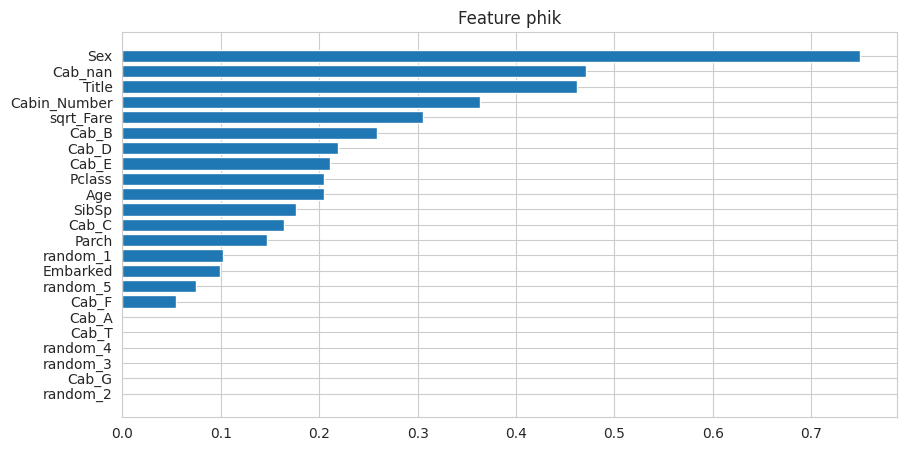

In [86]:
import phik


df_phik = (
    dataset.phik_matrix(interval_cols=dataset.columns)
    .round(3)
    .sort_values("Survived", ascending=False)
    .reset_index()[["index", "Survived"]][1:]
    .rename(columns={"index": "phik_feature", "Survived": "phik"})
    .reset_index(drop=True)
)

sorted_idx = np.argsort(df_phik["phik"])
fig = plt.figure(figsize=(10, 5))
plt.barh(range(df_phik.shape[0]), df_phik["phik"].iloc[sorted_idx], align="center")
plt.yticks(range(df_phik.shape[0]), df_phik["phik_feature"].iloc[sorted_idx])
plt.title("Feature phik")
plt.show()

Посмотрим все методы в общей таблице, чтобы сравнить порядок признаков:

In [87]:
pd.concat([df_mi, df_rocs, df_phik], axis=1)

,mi_feature,mutual_information,rocs_feature,rocs,phik_feature,phik
0,Title,0.151241,Title,0.775,Sex,0.750
1,Sex,0.124928,Sex,0.766,Cab_nan,0.471
2,sqrt_Fare,0.107579,sqrt_Fare,0.677,Title,0.462
3,Pclass,0.072095,Pclass,0.674,Cabin_Number,0.363
4,Cabin_Number,0.059620,Cab_nan,0.629,sqrt_Fare,0.306
5,random_3,0.049722,Cabin_Number,0.627,Cab_B,0.259
6,Cab_nan,0.048813,Embarked,0.567,Cab_D,0.219
7,Age,0.034909,Parch,0.559,Cab_E,0.211
8,Cab_B,0.034109,random_1,0.550,Pclass,0.205
9,Cab_E,0.020871,Cab_B,0.541,Age,0.205


Как мы видим, не все случайные признаки находятся в самом низу. Некоторые из них имеют более высокую оценку, чем наши исходные.

**Важно!** Это не означает, что признаки, которые находятся ниже случайных, плохие.

### Проблемы одномерного отбора признаков

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/problems_of_one_dimensional_feature_selection.png" alt="alttext" width="600"/></center>

У подхода, при котором важности всех признаков оцениваются по отдельности, есть свои недостатки. На левом рисунке изображена двумерная выборка, для которой необходимо решить задачу классификации. Если спроецировать данную выборку на ось абсцисс, то она будет разделима, хотя и будут присутствовать ошибки. Если же спроецировать данную выборку на ось ординат, то все объекты разных классов перемешаются, и выборка будет неразделима. В этом случае при использовании любого метода одномерного оценивания информативности первый признак будет информативен, а второй — совершенно неинформативен.

Тем не менее, видно, что если использовать эти признаки одновременно, то классы будут разделимы идеально. Второй признак важен, но он важен только в совокупности с первым, и методы одномерного оценивания информативности не способны это определить.

На рисунке справа показана выборка, на которой одномерные методы оценки информативности работают ещё хуже. В этом случае, если спроецировать выборку на ось абсцисс или ординат, то объекты классов перемешаются и в обоих случаях данные будут совершенно неразделимы. И, согласно любому из описанных методов, оба признака неинформативны. Тем не менее, если использовать их одновременно, то, например, решающее дерево может идеально решить данную задачу классификации.

Пример: влияние роста и веса при предсказании вероятности сердечного заболевания. Избыточный вес может являться важным фактором, но оценить, является ли он избыточным или нормальным, можно только зная рост пациента.

## Отбор признаков на основе моделей

### Линейная модель

Использование весов признаков.

В линейных моделях перед признаками стоят веса. Веса при признаках можно интерпретировать как информативности: чем больше по модулю вес при признаке, тем больший вклад этот признак вносит в ответ модели.

**Важно! Признаки должны быть отмасштабированы!**

Дополнительно можно использовать регулиризацию для отбора признаков.

Чем больше коэффициент при L1-регуляризаторе, тем меньше признаков будет использовать линейная модель (она занулит неинформативные признаки).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/weight_importances.png" width="600"></center>

[[doc] 🛠️ Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Обучим линейную модель и посмотрим на веса для признаков:

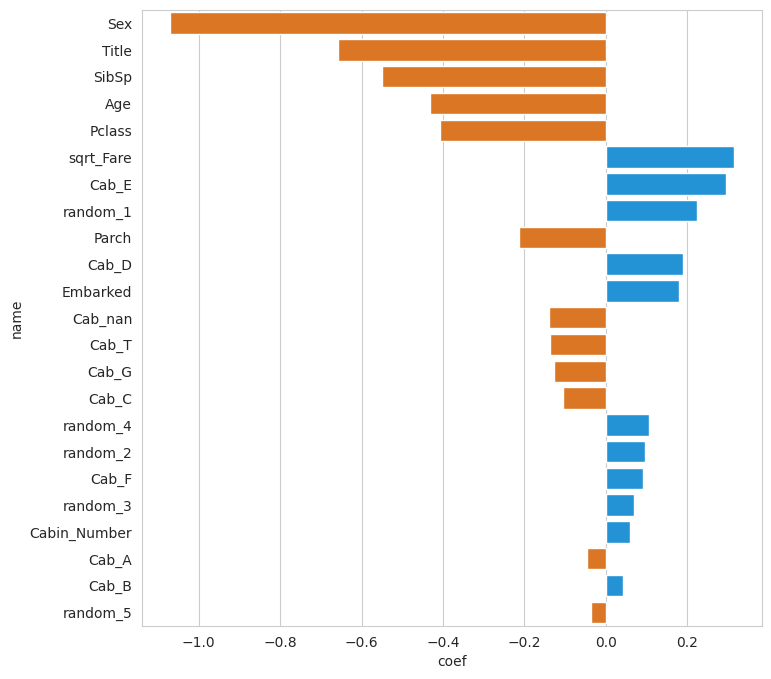

In [88]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_scaled, y_train)

df_temp = pd.DataFrame({"name": x_train.columns, "coef": lr.coef_[0]}).sort_values(
    "coef", key=abs, ascending=False
)

df_temp["sign"] = ["neg" if x < 0 else "pos" for x in df_temp["coef"]]

palette = {"neg": sns.xkcd_rgb["orange"], "pos": sns.xkcd_rgb["azure"]}

plt.figure(figsize=(8, 8))
sns.barplot(
    data=df_temp,
    y="name",
    x="coef",
    hue="sign",
    palette=palette,
    legend=False,
    orient="h",
)
plt.show()

Можно использовать `SelectFromModel` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) из библиотеки Sklearn для отбора наиболее значимых признаков:

In [89]:
from sklearn.feature_selection import SelectFromModel


# Selecting features based on importance weights
lr_selector = SelectFromModel(LogisticRegression(max_iter=1000))
lr_selector.fit(x_train_scaled, y_train)
x_train.columns[lr_selector.get_support()]  # Get a mask of the features selected

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Title', 'sqrt_Fare', 'Cab_E'], dtype='object')

### Случайный лес

У случайного леса тоже есть свои важности признаков, только в этом случае важность признака определяется так: чем больше признак уменьшает impurity при разбиении, тем он более важный:

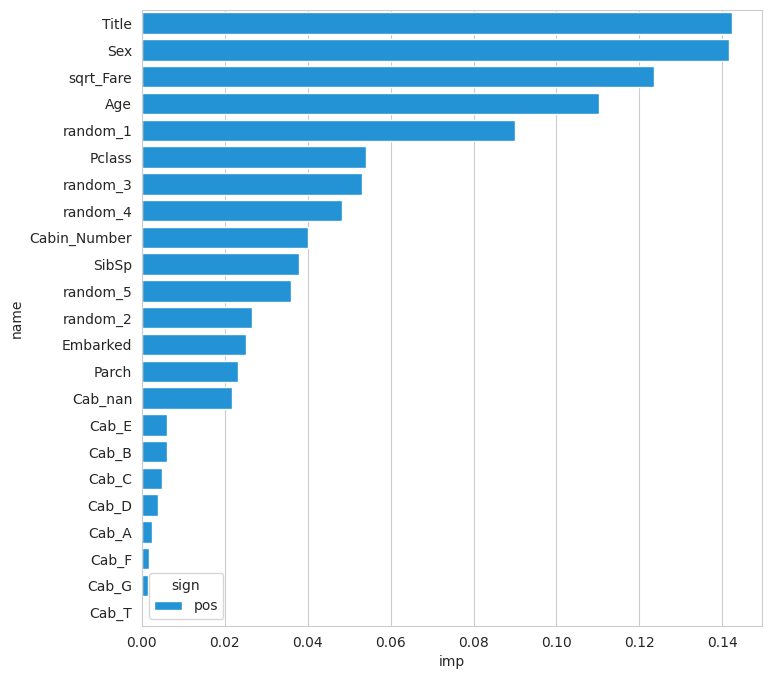

In [90]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(x_train, y_train)

df_temp = pd.DataFrame(
    {"name": x_train.columns, "imp": rf.feature_importances_}
).sort_values("imp", key=abs, ascending=False)

df_temp["sign"] = ["neg" if x < 0 else "pos" for x in df_temp["imp"]]

palette = {"neg": sns.xkcd_rgb["orange"], "pos": sns.xkcd_rgb["azure"]}

plt.figure(figsize=(8, 8))
sns.barplot(data=df_temp, y="name", x="imp", hue="sign", palette=palette, orient="h")
plt.show()

In [91]:
# Select features with RFC
rf = RandomForestClassifier(n_estimators=500, random_state=42)

rf_selector = SelectFromModel(rf)
rf_selector.fit(x_train, y_train)  # Fit it on the training data

x_train.columns[rf_selector.get_support()]

Index(['Pclass', 'Sex', 'Age', 'Title', 'sqrt_Fare', 'random_1', 'random_3',
       'random_4'],
      dtype='object')

### Градиентный бустинг

Такие же важности можно вытащить из градиентного бустинга. Рассмотрим на примере CatBoost:

In [92]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


In [93]:
from catboost import CatBoostClassifier


model = CatBoostClassifier(random_state=42, thread_count=-1)
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=100,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.029139
0:	learn: 0.6801871	test: 0.6814320	best: 0.6814320 (0)	total: 49.4ms	remaining: 49.3s
100:	learn: 0.3289676	test: 0.4295331	best: 0.4285715 (95)	total: 207ms	remaining: 1.84s
200:	learn: 0.2694309	test: 0.4232609	best: 0.4215241 (180)	total: 551ms	remaining: 2.19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.42152413
bestIteration = 180

Shrink model to first 181 iterations.


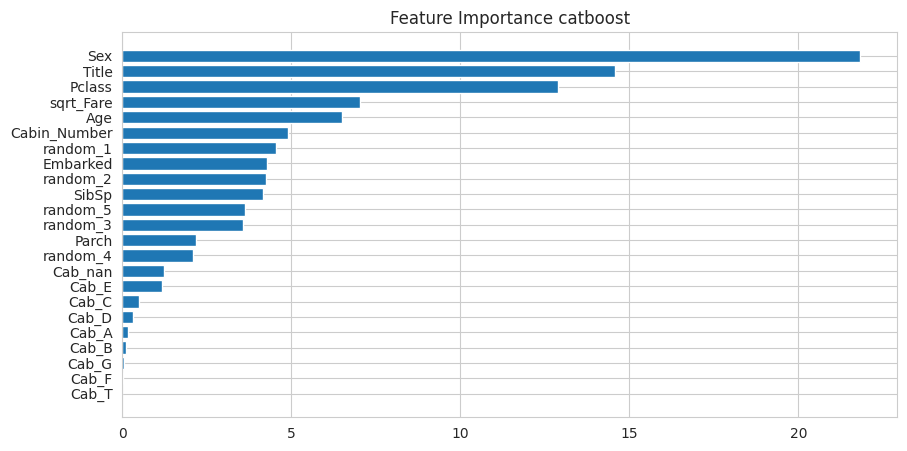

In [94]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title("Feature Importance catboost")
plt.show()

В CatBoost также есть свой метод отбора признаков `select_features` [🛠️[doc]](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features). Можно указать, какие признаки рассматривать для отбора (мы рассмотрим все признаки, параметр `features_for_select`), и количество признаков, которые нужно отобрать, — `num_features_to_select`. Для примера отберем 5 признаков:

In [95]:
summary = model.select_features(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    features_for_select="0-22",
    num_features_to_select=5,
    steps=1,
    train_final_model=False,
    logging_level="Silent",
)

In [96]:
print(summary["selected_features_names"])

['Pclass', 'Sex', 'Title', 'Cabin_Number', 'sqrt_Fare']


## Randomization/Permutation



Для определения важности признака можно перемешать его значения. Это не изменит форму распределения признака, но сделает его бессмысленным. По качеству модели мы можем оценить, каков был вклад признака до изменения: если качество упало сильно, то он был значимым.

В Sklearn это реализовано как отдельный класс `permutation_importance` [🛠️[doc]](https://scikit-learn.org/stable/modules/permutation_importance.html).

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/permutation_importance_example.png" width="1000"/></center>

Изменение качества модели рассчитывается на объектах, которые не вошли в обучающую выборку, а остались для валидации (не путать с тестовой выборкой, которую мы не трогаем).

У данного метода есть три особенности:
1. Значение **важности признака** будет зависеть от **результата перемешивания**, которое носит случайный характер. Поэтому функция `permutation_importance` имеет параметр `n_repeats`, который определяет, сколько раз признак будет перемешиваться случайным образом.
2. Значение **важности признака** будет зависеть от **модели** и того, насколько “удачно” она обучена. “Плохая” и “хорошая” модели могут считать важным разный набор признаков. Поэтому полезно сравнить важность признаков модели, обучив модель на различных выборках (например, используя кросс-валидацию).
3. Данный метод неадекватно оценивает **важность коррелированных признаков**.

Для борьбы с неадекватной оценкой **коррелированных признаков** можно собрать коррелированные признаки в кластеры и оставить  только один признак для каждого [кластера 🛠️[doc]](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py).

Одна из вариаций `permutation_importance` подразумевает **обучение модели заново** после каждого **перемешивания признаков**. Это дает чуть более адекватную оценку важности, но очень долго.

### Пример отбора признаков с помощью permutation importance

Делаем `permutation_importance` следующим образом:

1. Обучаем модель.
2. Перемешиваем значения в одном столбце (одного признака), делаем предсказание на валидационном наборе данных и считаем ошибку. Увеличение ошибки показывает важность признака, который перемешали.
3. Возвращаем значения признака и повторяем шаг 2 со всеми остальными признаками.

Ниже выполняются эти же операции, но уже с линейной моделью:

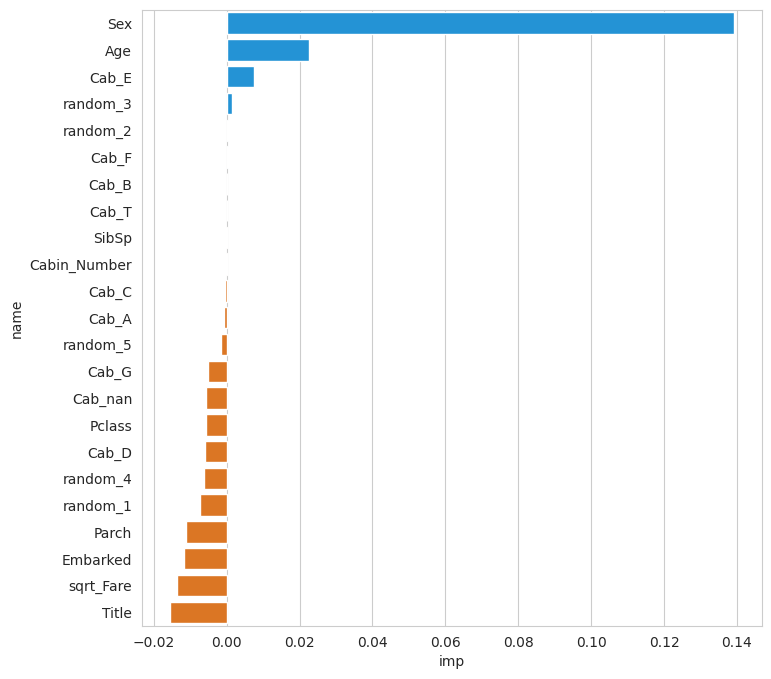

In [97]:
from sklearn.inspection import permutation_importance


model = LogisticRegression()
model.fit(x_train_scaled, y_train)

r = permutation_importance(model, x_test_scaled, y_test, n_repeats=100, random_state=42)

df_temp = pd.DataFrame(
    {"name": x_train.columns, "imp": r.importances_mean}
).sort_values("imp", ascending=False)
df_temp["sign"] = ["neg" if x < 0 else "pos" for x in df_temp["imp"]]

palette = {"neg": sns.xkcd_rgb["orange"], "pos": sns.xkcd_rgb["azure"]}

plt.figure(figsize=(8, 8))
sns.barplot(
    data=df_temp,
    y="name",
    x="imp",
    hue="sign",
    palette=palette,
    legend=False,
    orient="h",
)
plt.show()

И со случайным лесом:

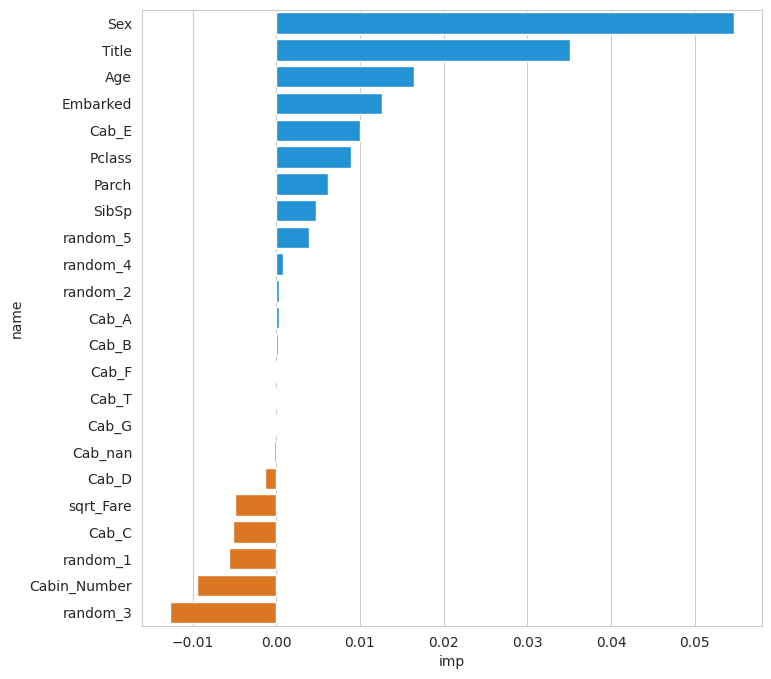

In [98]:
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(x_train, y_train)

r = permutation_importance(model, x_test, y_test, n_repeats=100, random_state=42)

df_temp = pd.DataFrame(
    {"name": x_train.columns, "imp": r.importances_mean}
).sort_values("imp", ascending=False)

df_temp["sign"] = ["neg" if x < 0 else "pos" for x in df_temp["imp"]]

palette = {"neg": sns.xkcd_rgb["orange"], "pos": sns.xkcd_rgb["azure"]}

plt.figure(figsize=(8, 8))
sns.barplot(
    data=df_temp,
    y="name",
    x="imp",
    hue="sign",
    palette=palette,
    legend=False,
    orient="h",
)
plt.show()

Как видно, у некоторых признаков при переходе от древесных моделей к линейным важность признаков изменилась.

## Boruta

Boruta развивает идею Permutation.

Увеличим наш датасет, добавив в него "теневые признаки" $-$ перемешанные реальные. Таким образом, наш датасет точно будет содержать хорошие признаки (мы ничего не удаляем).

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/boruta_idea.png" width="800"/></center>

После этого обучаем модель (по умолчанию в Boruta обучается Random Forest) и отбираем те признаки, чей `feature_importance` больше, чем у лучшего из теневых. Удаляем старые теневые признаки, генерируем новые. Повторяем процедуру несколько раз для того, чтобы удалить случайные скачки качества.

Таким образом, для каждого признака мы будем знать, сколько раз мы его отобрали. Получаем распределение. Самая большая неопределенность будет в середине (вероятность отобрать = 0.5):

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/boruta_diagram.png" alt="alttext" width="600"/></center>

[[blog] ✏️ Automated feature selection with boruta](https://www.kaggle.com/code/residentmario/automated-feature-selection-with-boruta)

Далее со значимостью, допустим, 0.05 берем все из «хорошего хвоста» и отбрасываем из «плохого хвоста». С признаками из середины колокола ничего особо не сделаешь: увеличение числа итераций приведет к ужатию колокола, но глобально не поможет.

Если нам нужна хорошо интерпретируемая модель, то надо брать только точно хорошие признаки.

### Пример отбора признаков с помощью Boruta

Будем использовать реализацию [boruta_py 🐾[git]](https://github.com/scikit-learn-contrib/boruta_py). Возьмем Random Forest модель.

In [99]:
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

Попробуем применить алгоритм Boruta к этому же датасету и сократить количество признаков.
Оценим текущее качество модели, используя ROC-AUC:

In [100]:
pred = model.predict_proba(x_test)[:, 1]
r1 = roc_auc_score(y_score=pred, y_true=y_test)

print(f"ROC-AUC: {r1:.4f}")

ROC-AUC: 0.8868


Установим Boruta:

In [101]:
!pip install -q boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.7 MB/s eta 0:00:00


Питоновская реализация Boruta соответствует  API Sklearn и может использоваться как в конвейере, так и самостоятельно.

Boruta работает с `numpy.array`, поэтому используем `.values()` :

In [102]:
print(type(x_train))
print(type(x_train.values))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


Проведем оценку признаков при помощи Boruta.



In [103]:
from boruta import BorutaPy

# for NumPy and Boruta compatibility
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

# define Boruta feature selection method
model = RandomForestClassifier(n_estimators=500, random_state=42)

feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)

# find all relevant features
feat_selector.fit(x_train.values, y_train.values)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100


BorutaPy finished running.

Iteration: 	27 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	19


BorutaPy(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7D178E928A40),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7D178E928A40,
         verbose=1)

Посмотрим, как оценила признаки Boruta:

In [104]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

features keep: ['Sex', 'Age', 'Title', 'sqrt_Fare']
features normal: []
features drop: ['Pclass', 'SibSp', 'Parch', 'Embarked', 'Cabin_Number', 'Cab_A', 'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_nan', 'random_1', 'random_2', 'random_3', 'random_4', 'random_5']


Посмотрим на более подробную информацию о результатах отбора:

In [105]:
feature_ranks = list(
    zip(x_train.columns, feat_selector.ranking_, feat_selector.support_)
)

df_temp = pd.DataFrame(feature_ranks, columns=["feature", "rank", "boruta_keep"])
df_temp.sort_values("rank")

,feature,rank,boruta_keep
1,Sex,1,True
2,Age,1,True
6,Title,1,True
8,sqrt_Fare,1,True
0,Pclass,2,False
18,random_1,3,False
7,Cabin_Number,4,False
20,random_3,5,False
3,SibSp,6,False
21,random_4,7,False


Boruta из 23 признаков предлагает оставить только 4: **Sex, Age, Title, sqrt_Fare**.

 Зная информацию о ранге признака, мы можем взять больше признаков для обучения. Также обратите внимание, что случайный признак находится довольно высоко.



Обучим алгоритм на признаках, отобранных Boruta.
Давайте проверим, можем ли мы добиться такого же результата, если проанализируем и уберем «лишние» данные?

In [106]:
# Build the model with the random forest algorithm

model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(x_train[keep], y_train)

pred = model.predict_proba(x_test[keep])[:, 1]
r1 = roc_auc_score(y_score=pred, y_true=y_test)

print(f"ROC-AUC: {r1:.4f}")

ROC-AUC: 0.8702


Качество упало, но не так сильно. Можно поэкспериментировать с добавлением признаков более низкого ранга.

## Жадный отбор признаков

Самый простой способ решения задачи отбора признаков — это полный перебор всех подмножеств признаков и оценивание качества на каждом подмножестве.

Это подход хороший, он найдет оптимальное подмножество признаков, но при этом сложный, поскольку всего таких подмножеств $2^d -1$, где $d$ — число признаков. Если признаков много или алгоритм долго обучается, то такой перебор невозможен: он займет много времени.

**Полный перебор**

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/selection_complexity.png" width="1000"/></center>

Поэтому используют жадные методы отбора признаков, когда полный перебор не подходит для решения задачи. Например, может оказаться неплохой стратегия жадного наращивания (жадного добавления).

**Жадное добавление**

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/greedy_add_final.png" width="1000"/></center>



Процесс устроен следующим образом:

1. Находим один признак, который дает наилучшее качество модели. Добавляем такой признак в итоговое множество.
2. Находим следующий признак, который при добавлении к итоговому множеству улучшает качество.

Повторяем шаг 2 до тех пор, пока добавление нового признака не улучшает качество.

Также при необходимости можно сделать процедуру жадного удаления признаков (в зависимости от общего количества признаков и требуемого количества после отбора).


[[doc] 🛠️ Sequential Feature Selection for Regression](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-5-sequential-feature-selection-for-regression)

In [107]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


sfs = SequentialFeatureSelector(
    RandomForestClassifier(random_state=42),
    k_features=8,  # number of features to select
    forward=True,  # True - add, False - del
    floating=False,
    scoring="accuracy",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)
sfs.fit(x_train, y_train)

df_temp = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df_temp.head(df_temp.shape[0])

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[0.8181818181818182, 0.7482517482517482, 0.753...",0.787935,"(Sex,)",0.040774,0.031724,0.015862
2,"(1, 4)","[0.8181818181818182, 0.7552447552447552, 0.767...",0.794967,"(Sex, Parch)",0.037359,0.029067,0.014533
3,"(1, 4, 8)","[0.8041958041958042, 0.8181818181818182, 0.774...",0.814616,"(Sex, Parch, sqrt_Fare)",0.032575,0.025345,0.012672
4,"(1, 4, 8, 14)","[0.7972027972027972, 0.8251748251748252, 0.781...",0.82025,"(Sex, Parch, sqrt_Fare, Cab_F)",0.037555,0.029219,0.014609
5,"(1, 4, 8, 14, 16)","[0.7972027972027972, 0.8321678321678322, 0.781...",0.82024,"(Sex, Parch, sqrt_Fare, Cab_F, Cab_T)",0.037626,0.029274,0.014637
6,"(0, 1, 4, 8, 14, 16)","[0.8181818181818182, 0.8251748251748252, 0.781...",0.823038,"(Pclass, Sex, Parch, sqrt_Fare, Cab_F, Cab_T)",0.032031,0.024921,0.012461
7,"(0, 1, 4, 8, 14, 15, 16)","[0.8111888111888111, 0.8251748251748252, 0.781...",0.825864,"(Pclass, Sex, Parch, sqrt_Fare, Cab_F, Cab_G, ...",0.038813,0.030198,0.015099
8,"(0, 1, 4, 8, 13, 14, 15, 16)","[0.8111888111888111, 0.8251748251748252, 0.767...",0.824456,"(Pclass, Sex, Parch, sqrt_Fare, Cab_E, Cab_F, ...",0.045308,0.035251,0.017626


In [108]:
df_temp["feature_names"].values[-1]

('Pclass', 'Sex', 'Parch', 'sqrt_Fare', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T')

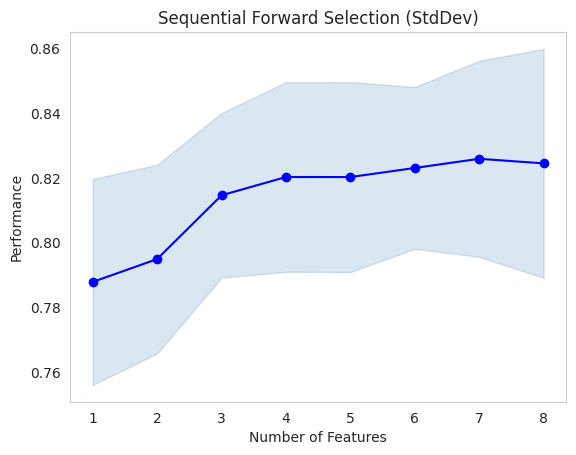

In [109]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict(), kind="std_dev")

plt.title("Sequential Forward Selection (StdDev)")
plt.grid()
plt.show()

### ADD-DEL

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/add_vs_del.png" width="1000"></center>

В описанном выше подходе есть существенный минус — мы только добавляем (или удаляем) признаки. Может случиться такая ситуация, когда удаление добавленного в начале признака из итогового подмножества улучшит качество.

Процесс выглядит следующим образом:

1. Начинаем с процедуры жадного добавления. Находим один признак, который дает наилучшее качество модели. Добавляем такой признак в итоговое множество.
2. Находим следующий признак который при добавлении к итоговому множеству улучшает качество.
3. Когда добавление нового признака не улучшает качество, начинаем процедуру жадного удаления. Ищем признак, удаление которого улучшит качество модели.

Останавливаемся, когда удаление или добавление признака ухудшает качество.

Алгоритм ADD-DEL всё еще жадный, но при этом он менее жадный, чем предыдущий, поскольку *может исправлять ошибки*, сделанные в начале перебора: если вначале был добавлен неинформативный признак, то на этапе удаления от него можно избавиться.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.1/L04/out/add_del.png" width="1000"></center>

In [110]:
sffs = SequentialFeatureSelector(
    RandomForestClassifier(random_state=42),  # represents the classifier
    k_features=8,  # the number of features you want to select
    forward=True,  # add features
    floating=True,  # remove features
    scoring="accuracy",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sffs.fit(x_train.values, y_train)  # performs the actual SFFS algorithm
df_temp = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
df_temp.head(df_temp.shape[0])

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[0.8181818181818182, 0.7482517482517482, 0.753...",0.787935,"(1,)",0.040774,0.031724,0.015862
2,"(1, 4)","[0.8181818181818182, 0.7552447552447552, 0.767...",0.794967,"(1, 4)",0.037359,0.029067,0.014533
3,"(1, 4, 8)","[0.8041958041958042, 0.8181818181818182, 0.774...",0.814616,"(1, 4, 8)",0.032575,0.025345,0.012672
4,"(1, 4, 8, 14)","[0.7972027972027972, 0.8251748251748252, 0.781...",0.82025,"(1, 4, 8, 14)",0.037555,0.029219,0.014609
5,"(1, 4, 8, 14, 16)","[0.7972027972027972, 0.8321678321678322, 0.781...",0.82024,"(1, 4, 8, 14, 16)",0.037626,0.029274,0.014637
6,"(0, 1, 4, 8, 14, 16)","[0.8181818181818182, 0.8251748251748252, 0.781...",0.823038,"(0, 1, 4, 8, 14, 16)",0.032031,0.024921,0.012461
7,"(0, 1, 4, 8, 14, 15, 16)","[0.8111888111888111, 0.8251748251748252, 0.781...",0.825864,"(0, 1, 4, 8, 14, 15, 16)",0.038813,0.030198,0.015099
8,"(0, 1, 4, 8, 13, 14, 15, 16)","[0.8111888111888111, 0.8251748251748252, 0.767...",0.824456,"(0, 1, 4, 8, 13, 14, 15, 16)",0.045308,0.035251,0.017626


In [111]:
x.iloc[:, list(df_temp["feature_idx"].values[-1])].columns

Index(['Pclass', 'Sex', 'Parch', 'sqrt_Fare', 'Cab_E', 'Cab_F', 'Cab_G',
       'Cab_T'],
      dtype='object')

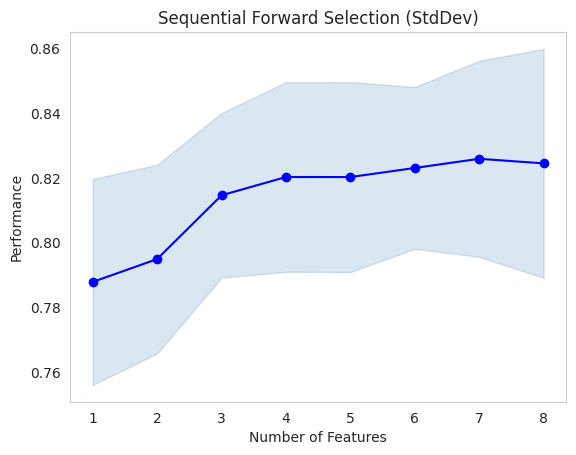

In [112]:
plot_sfs(sffs.get_metric_dict(), kind="std_dev")

plt.title("Sequential Forward Selection (StdDev)")
plt.grid()
plt.show()

## Рекомендации по отбору признаков

* Все методы отбора могут давать разные результаты, нужно использовать несколько и агрегировать их оценку.
* Начинайте с более простых и быстрых методов для оценки.
* Если объектов очень много, то можно использовать часть объектов для оценки, но важно, чтобы эта часть была репрезентативна.
* Отбор признаков чаще используется для интерпретации модели, анализа признаков и увеличения скорости работы, чем для улучшения качества предсказания.  

**Важно помнить**, что нельзя отбирать признаки на том же наборе данных, на котором тестируетесь. Иначе получите завышенное качество вашей модели.

[[colab] 🥨 Эксперимент с неправильным отбором признаков](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Classic_ML/experiment_feature_selection.ipynb)